<a href="https://colab.research.google.com/github/FelixSchmid/GANs_MNIST/blob/master/DCGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN



## Loading data

In [0]:
from tensorflow.keras.datasets import mnist
import numpy as np

In [0]:
(train_data,_),(test_data,_) = mnist.load_data()

In [0]:
data = np.concatenate((train_data,test_data),axis=0)

In [0]:
data.shape

(70000, 28, 28)

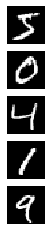

In [0]:
import matplotlib.pyplot as plt

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex], interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

In [0]:
# Normalization betwenn -1 and 1 !
quasi_mean = data.max()/2 # Max is always 255, so this works ok.
data = (data.astype(np.float32)-quasi_mean)/quasi_mean

In [0]:
# This is a convolutional model, so it works well with 2D data
data = data[...,np.newaxis]
data.shape

(70000, 28, 28, 1)

## Parameters

### Training parameters

We will be forced to do manual batching here, so we have to calcculate the number of batches manually, and iterate on a per batch basis.

In [0]:
EPOCHS = 200
BATCH_SIZE = 200
HALF_BATCH = BATCH_SIZE // 2
BATCH_NUM = (data.shape[0] // BATCH_SIZE)
if data.shape[0] % BATCH_SIZE:
    BATCH_NUM+=1
Z_DIM = 100


### Model parameters


Please remember:

<img src="https://miro.medium.com/max/760/1*B7y91tLgeWE-EuuFP-1XwA.png" width=65%>

And:

<img src="https://qph.fs.quoracdn.net/main-qimg-d4023fe66cac95238a76ea1b5bc21d84" wudth=45%>

In [0]:
GENERATOR_INITIAL_IMAGE_SIZE = 7
GENERATOR_INITIAL_IMAGE_CHANNELS = 128
GENERATOR_L1_DIM = GENERATOR_INITIAL_IMAGE_SIZE*GENERATOR_INITIAL_IMAGE_SIZE*GENERATOR_INITIAL_IMAGE_CHANNELS 
# eg. 7*7 image, 128 channels it will be, and we go DOWN with the channels from there

# We have to take care, that the final shape of all generator convolutions results in 28*28*1, 
# so it is a kind of balancing act
GENERATOR_L2_DIM = 64
GENERATOR_L2_KERNEL_SIZE = (5,5)
GENERATOR_OUTPUT_DIM = 1 # Number of output CHANNELS!
GENERATOR_OUTPUT_KERNEL_SIZE = (5,5)

GENERATOR_L3_DIM = 1024

DISCRIMINATOR_L1_DIM = 64
DISCRIMINATOR_L1_KERNEL_SIZE = (5,5)
DISCRIMINATOR_L2_DIM = 128
DISCRIMINATOR_L2_KERNEL_SIZE = (5,5)

LEAKY_ALPHA = 0.2

## Model building

In [0]:
from tensorflow.keras.optimizers import Adam

# Some empirically set values. 
# It might well be worth experimenting with newer optimizers / settings
optimizer = Adam(lr=2e-4, beta_1=0.5)

### Generator

In [0]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Conv2D, Flatten, Reshape, BatchNormalization, UpSampling2D
from tensorflow.keras.models import Model

In [0]:
### Define the generator!
#########################

# The generator always gets a noise vector as input
noise_input = Input(shape = (Z_DIM,))

g_layer_1 = Dense(GENERATOR_L1_DIM)(noise_input)

# But we do have to ensure that the input for anything convolutional is 2D + channel, so reshape is in order
# remeber, it is image szie * image size * channels
# and this is the initial "image"
reshaped_layer = Reshape((GENERATOR_INITIAL_IMAGE_SIZE,GENERATOR_INITIAL_IMAGE_SIZE,GENERATOR_INITIAL_IMAGE_CHANNELS))(g_layer_1)
g_layer_1_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(reshaped_layer)

# For stability, we add a batch normalization layer - no extra settings.
g_layer_1_batchnorm = BatchNormalization()(g_layer_1_nonlin)

# Now we use Upsampling to gradually get the image resolution up, by doubling
# upsampling layer does this without any extra parameters.
g_layer_2_upsample = UpSampling2D()(g_layer_1_batchnorm)
# As a result we have 14*14*128 - with the above default settings

# Furthermore we use convolutions to get the number of channels down
# Define a convolutional layer to get down to the layer 2 dimension of generator (number of filters)
g_layer_2_conv = Conv2D(filters=GENERATOR_L2_DIM, kernel_size=GENERATOR_L2_KERNEL_SIZE, padding='same')(g_layer_2_upsample)
# As a result we get 14*14*64 - with the above default settings

g_layer_2_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_2_conv)
g_layer_2_batchnorm = BatchNormalization()(g_layer_2_nonlin)

# Now we again use Upsampling to gradually get the image resolution up, by doubling
g_layer_3_upsample = UpSampling2D()(g_layer_2_batchnorm)
# As a result we have 28*28*64 - with the above default settings

# Furthermore we use Conv2D to get the number of channels down
# Define a convolutional layer to get down to the output layer dimension of generator (number of filters)
g_output_layer = Conv2D(filters=GENERATOR_OUTPUT_DIM, kernel_size=GENERATOR_OUTPUT_KERNEL_SIZE, padding='same', activation='tanh')(g_layer_3_upsample)
# As a result we get 28*28*1 - with the above default settings
# And please notice, that we used an activation, so our pixels get between -1 and 1 again
# This should now be indistinguishable from an input image - hopefully

# Please instantiate the model!
generator = Model(inputs=noise_input, outputs=g_output_layer)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Discriminator

In [0]:
### Define the discriminator!
#############################

# We still use FUNCTIONAL API!

# The discriminator always gets original sized images, so 28x28x1 (channel) as inputs
image_input = Input(shape=(data.shape[1],data.shape[2],data.shape[3]))

d_layer_1 = Conv2D(filters=DISCRIMINATOR_L1_DIM, kernel_size=DISCRIMINATOR_L1_KERNEL_SIZE, strides=(2,2), padding='same')(image_input)
d_layer_1_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(d_layer_1)

d_layer_2 = Conv2D(filters=DISCRIMINATOR_L2_DIM, kernel_size=DISCRIMINATOR_L2_KERNEL_SIZE, strides=(2,2), padding='same')(d_layer_1_nonlin)
d_layer_2_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(d_layer_2)

# to make the output of the previos conv compatible with a fully connected layer!
d_layer_2_flattened = Flatten()(d_layer_2_nonlin)
d_output_layer = Dense(1, activation='sigmoid')(d_layer_2_flattened)

discriminator = Model(inputs=image_input, outputs=d_output_layer)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Joint model

In [0]:
### Define the GAN itself!
##########################

# This is a crucial line, since in the joint model, discriminator will be frozen, so no weight update!
discriminator.trainable = False

gan_input = Input(shape=(Z_DIM,))
# Use the generator as a function on the input!
generated_image = generator(gan_input)
# Use the discriminator as a function on the fake images!
gan_output = discriminator(generated_image)
# Instantiate the joint model, appropriate input and output!
joint_model = Model(inputs=gan_input, outputs=gan_output)
joint_model.compile(loss='binary_crossentropy', optimizer=optimizer)

## Helper functions for visualization

In [0]:
# Nothing to see here! :-P

from matplotlib import pyplot as plt
import matplotlib.image as mpimg


def get_example_images(epoch, example_count=25):
    input_noise = np.random.normal(0,1, size=(example_count,Z_DIM))
    generated_images = generator.predict(input_noise)
    generated_images = generated_images.reshape(example_count, 28, 28)
    
    plt.figure(figsize = (5, example_count // 5))
    for ex in range(example_count):
        plt.subplot(5, example_count//5, ex+1)
        plt.imshow(generated_images[ex], interpolation="nearest", cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("DCGAN_example_images_epoch_num_{0}.png".format(epoch))

def show_image_for_epoch(epoch):
    imgname = "DCGAN_example_images_epoch_num_"+str(epoch)+".png"
    img = mpimg.imread(imgname)
    imgplot = plt.imshow(img)
    plt.show()


## Training

Sadly, we can not use simple `fit()`, but have to construct the main training loop ourselves.

  0%|          | 0/350 [00:00<?, ?it/s]

100%|██████████| 350/350 [00:21<00:00, 16.22it/s]


Epoch number: 0 discriminator_loss: 0.6124637869426183 generator_loss: 0.7366395755325045


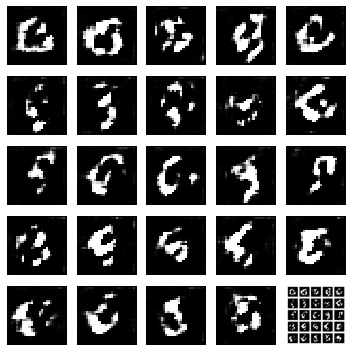

100%|██████████| 350/350 [00:18<00:00, 19.17it/s]


Epoch number: 1 discriminator_loss: 0.7169496849605015 generator_loss: 0.8831922146252223


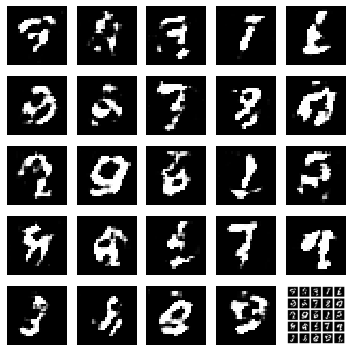

100%|██████████| 350/350 [00:18<00:00, 19.26it/s]


Epoch number: 2 discriminator_loss: 0.6982220888137818 generator_loss: 0.8579917410441807


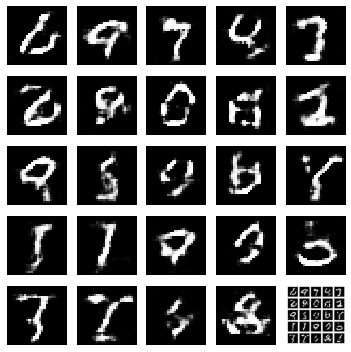

100%|██████████| 350/350 [00:18<00:00, 19.26it/s]


Epoch number: 3 discriminator_loss: 0.7009085667133331 generator_loss: 0.8323764298643385


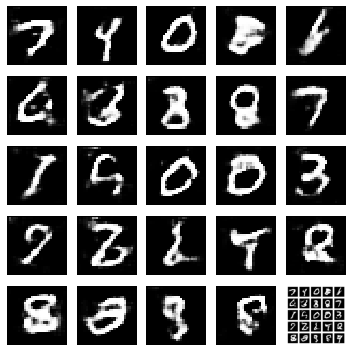

100%|██████████| 350/350 [00:18<00:00, 19.21it/s]


Epoch number: 4 discriminator_loss: 0.6957782621043069 generator_loss: 0.8265330990723201


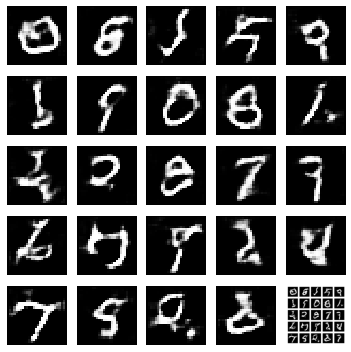

100%|██████████| 350/350 [00:18<00:00, 19.16it/s]


Epoch number: 5 discriminator_loss: 0.692155613047736 generator_loss: 0.8318339620317732


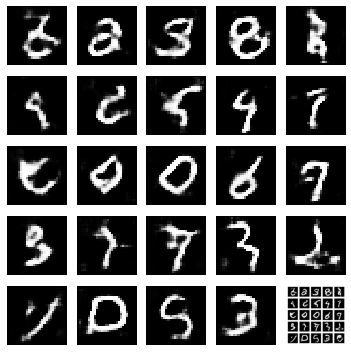

100%|██████████| 350/350 [00:18<00:00, 18.89it/s]


Epoch number: 6 discriminator_loss: 0.689815456186022 generator_loss: 0.8315279257297515


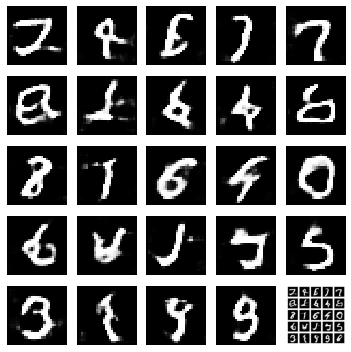

100%|██████████| 350/350 [00:18<00:00, 19.16it/s]


Epoch number: 7 discriminator_loss: 0.6885468563011714 generator_loss: 0.831282160963331


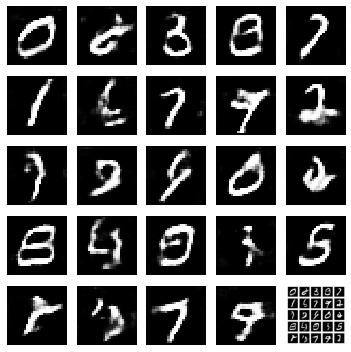

100%|██████████| 350/350 [00:18<00:00, 19.01it/s]


Epoch number: 8 discriminator_loss: 0.6870654382024493 generator_loss: 0.8338702501569475


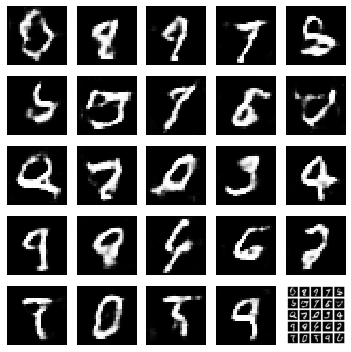

100%|██████████| 350/350 [00:18<00:00, 19.52it/s]


Epoch number: 9 discriminator_loss: 0.6858357870578766 generator_loss: 0.837794269323349


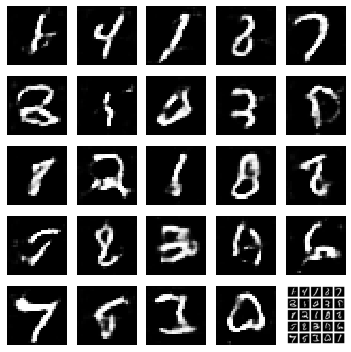

100%|██████████| 350/350 [00:18<00:00, 19.45it/s]


Epoch number: 10 discriminator_loss: 0.6850110139165606 generator_loss: 0.8367149298531669


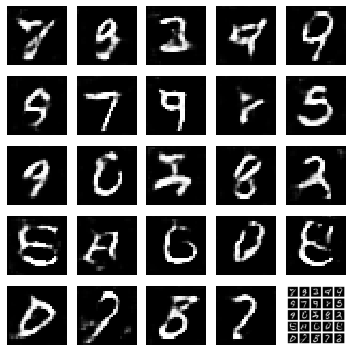

100%|██████████| 350/350 [00:18<00:00, 19.44it/s]


Epoch number: 11 discriminator_loss: 0.6841594227722713 generator_loss: 0.8402216844899314


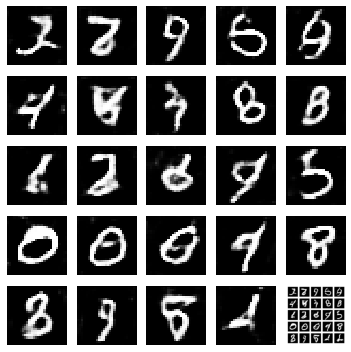

100%|██████████| 350/350 [00:18<00:00, 19.38it/s]


Epoch number: 12 discriminator_loss: 0.6836674761772156 generator_loss: 0.8404053592681885


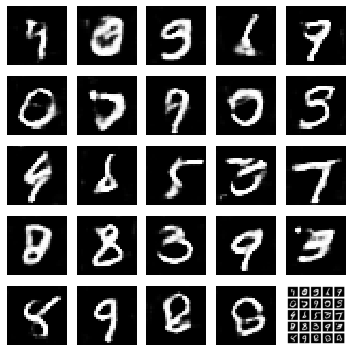

100%|██████████| 350/350 [00:18<00:00, 19.46it/s]


Epoch number: 13 discriminator_loss: 0.682693885905402 generator_loss: 0.8486435220922742


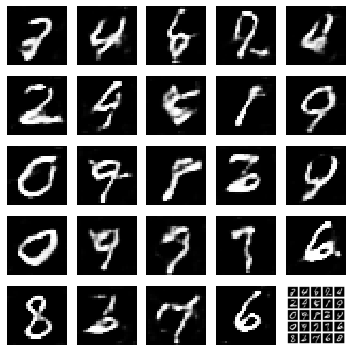

100%|██████████| 350/350 [00:17<00:00, 19.49it/s]


Epoch number: 14 discriminator_loss: 0.6828111125741686 generator_loss: 0.837844992024558


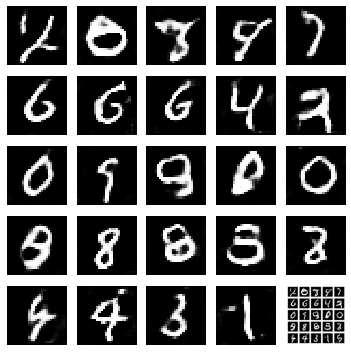

100%|██████████| 350/350 [00:18<00:00, 19.39it/s]


Epoch number: 15 discriminator_loss: 0.6808740159443446 generator_loss: 0.8578490592752184


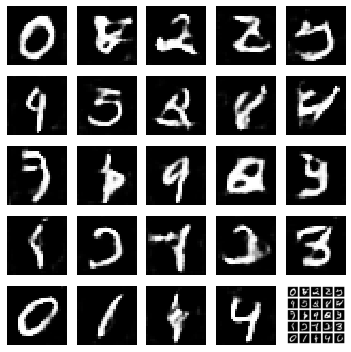

100%|██████████| 350/350 [00:18<00:00, 19.40it/s]


Epoch number: 16 discriminator_loss: 0.6812806013652256 generator_loss: 0.8487163829803467


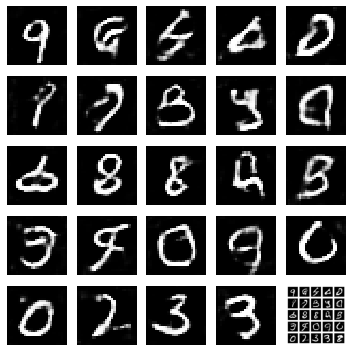

100%|██████████| 350/350 [00:18<00:00, 19.65it/s]


Epoch number: 17 discriminator_loss: 0.6803755751677922 generator_loss: 0.8488258111476898


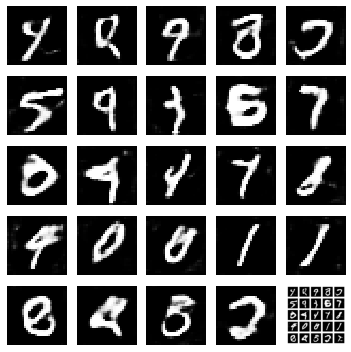

100%|██████████| 350/350 [00:18<00:00, 18.71it/s]


Epoch number: 18 discriminator_loss: 0.6787489296708789 generator_loss: 0.8649415263107845


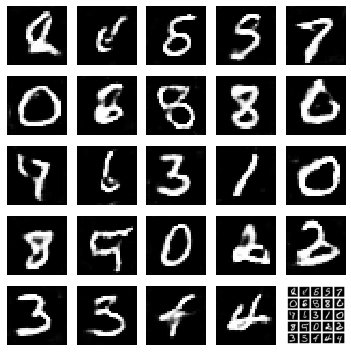

100%|██████████| 350/350 [00:18<00:00, 18.26it/s]


Epoch number: 19 discriminator_loss: 0.6783695747171129 generator_loss: 0.8563936381680625


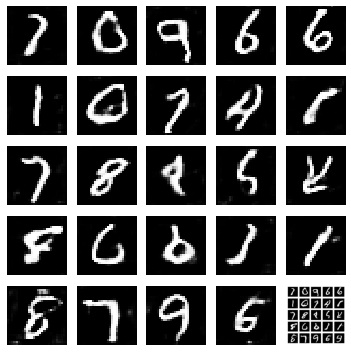

100%|██████████| 350/350 [00:18<00:00, 18.34it/s]


Epoch number: 20 discriminator_loss: 0.6763366539137704 generator_loss: 0.8752699375152588


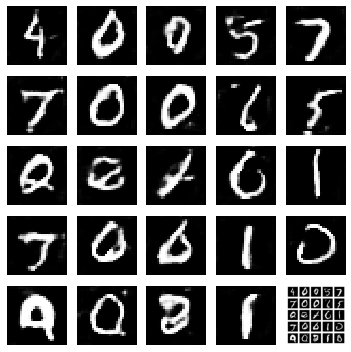

100%|██████████| 350/350 [00:18<00:00, 18.83it/s]


Epoch number: 21 discriminator_loss: 0.6765177580288478 generator_loss: 0.8643574041979654


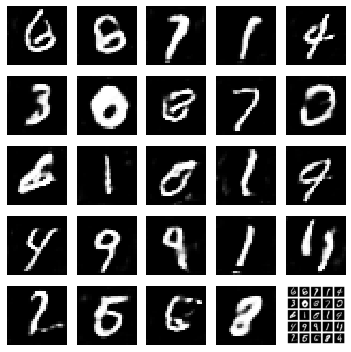

100%|██████████| 350/350 [00:18<00:00, 18.59it/s]


Epoch number: 22 discriminator_loss: 0.6739538267680577 generator_loss: 0.8898582742895399


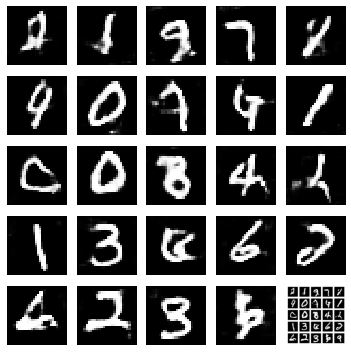

100%|██████████| 350/350 [00:19<00:00, 18.60it/s]


Epoch number: 23 discriminator_loss: 0.674089469909668 generator_loss: 0.8729049040590013


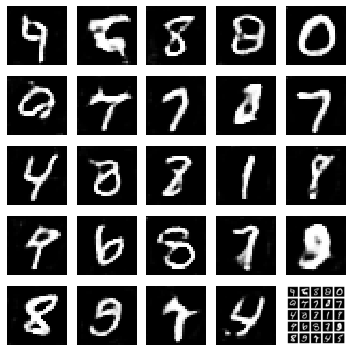

100%|██████████| 350/350 [00:18<00:00, 18.74it/s]


Epoch number: 24 discriminator_loss: 0.6730350238936288 generator_loss: 0.8826574254035949


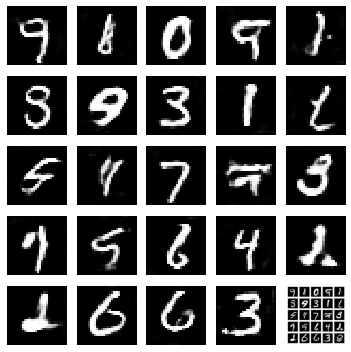

100%|██████████| 350/350 [00:18<00:00, 18.87it/s]


Epoch number: 25 discriminator_loss: 0.6721610140800476 generator_loss: 0.8863581221444267


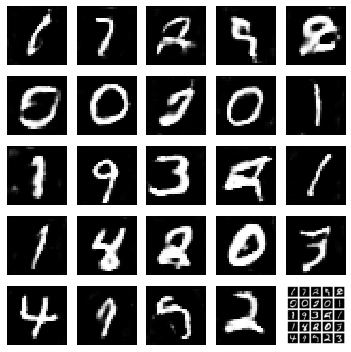

100%|██████████| 350/350 [00:18<00:00, 18.36it/s]


Epoch number: 26 discriminator_loss: 0.6711315660817283 generator_loss: 0.8891130232810974


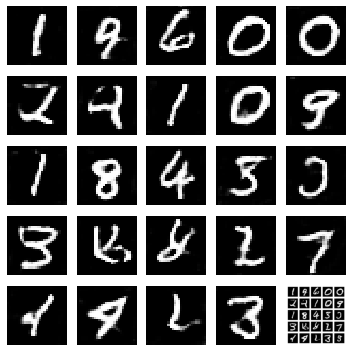

100%|██████████| 350/350 [00:18<00:00, 18.82it/s]


Epoch number: 27 discriminator_loss: 0.6690770062378475 generator_loss: 0.8965227939401355


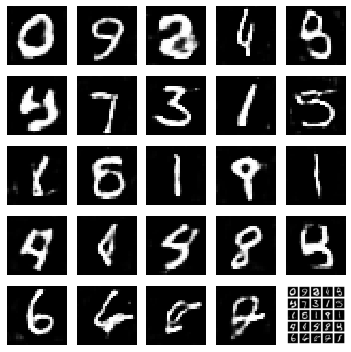

100%|██████████| 350/350 [00:18<00:00, 18.43it/s]


Epoch number: 28 discriminator_loss: 0.6677229716096605 generator_loss: 0.9094569662639073


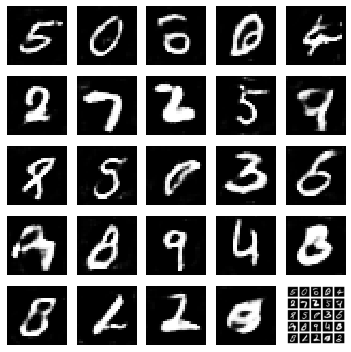

100%|██████████| 350/350 [00:18<00:00, 18.91it/s]


Epoch number: 29 discriminator_loss: 0.6664267759663718 generator_loss: 0.9065660183770315


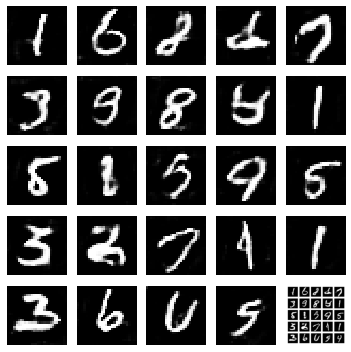

100%|██████████| 350/350 [00:18<00:00, 18.76it/s]


Epoch number: 30 discriminator_loss: 0.665732056753976 generator_loss: 0.9130817706244333


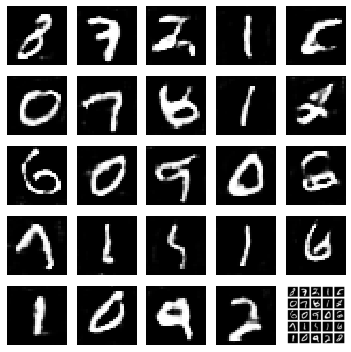

100%|██████████| 350/350 [00:18<00:00, 19.02it/s]


Epoch number: 31 discriminator_loss: 0.6643812884603227 generator_loss: 0.9259640046528408


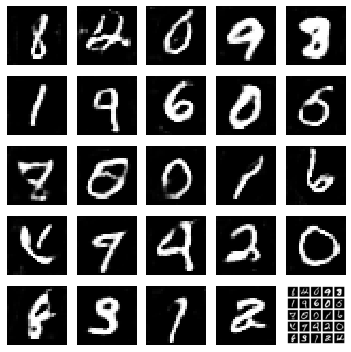

100%|██████████| 350/350 [00:18<00:00, 18.96it/s]


Epoch number: 32 discriminator_loss: 0.6626553578036172 generator_loss: 0.9290716188294547


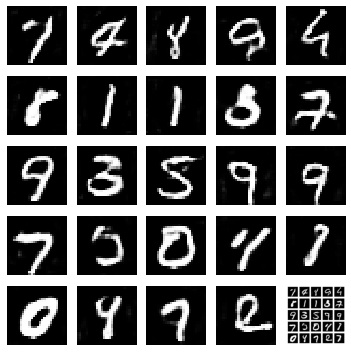

100%|██████████| 350/350 [00:18<00:00, 18.88it/s]


Epoch number: 33 discriminator_loss: 0.6615186224664961 generator_loss: 0.9308038684300014


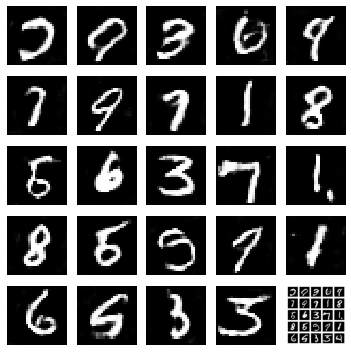

100%|██████████| 350/350 [00:18<00:00, 19.22it/s]


Epoch number: 34 discriminator_loss: 0.6602846349988665 generator_loss: 0.9373307384763445


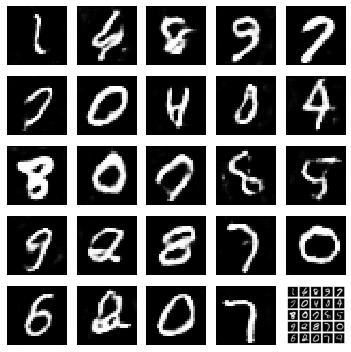

100%|██████████| 350/350 [00:18<00:00, 19.22it/s]


Epoch number: 35 discriminator_loss: 0.6589516622679574 generator_loss: 0.9465928953034537


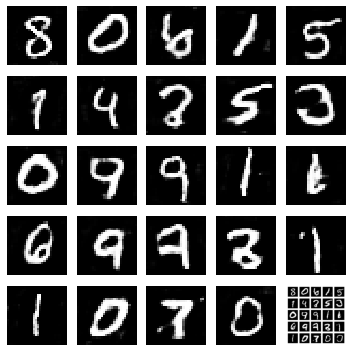

100%|██████████| 350/350 [00:18<00:00, 19.16it/s]


Epoch number: 36 discriminator_loss: 0.6565801048278809 generator_loss: 0.9567975904260363


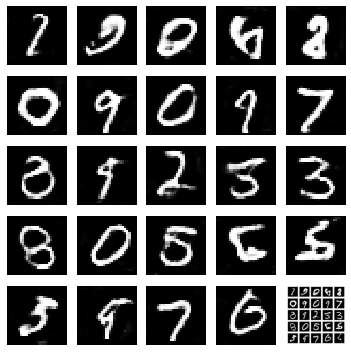

100%|██████████| 350/350 [00:18<00:00, 19.05it/s]


Epoch number: 37 discriminator_loss: 0.6549306680474962 generator_loss: 0.9607799800804683


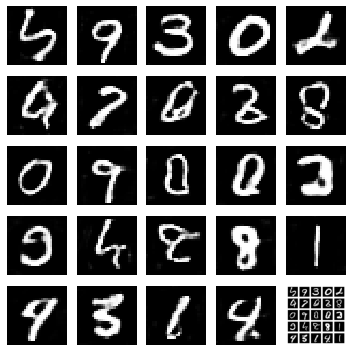

100%|██████████| 350/350 [00:18<00:00, 19.15it/s]


Epoch number: 38 discriminator_loss: 0.654678327866963 generator_loss: 0.9689202243941171


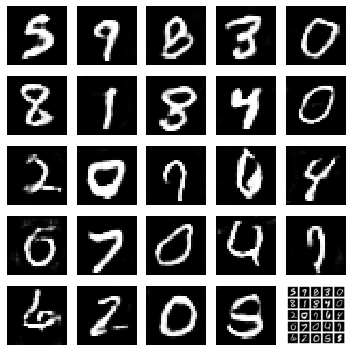

100%|██████████| 350/350 [00:18<00:00, 19.20it/s]


Epoch number: 39 discriminator_loss: 0.651746666601726 generator_loss: 0.9769630326543536


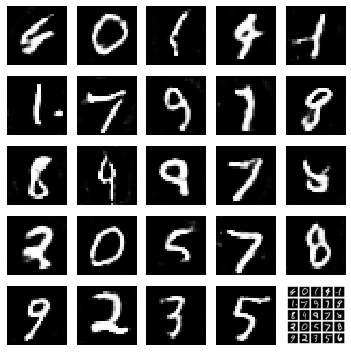

100%|██████████| 350/350 [00:18<00:00, 19.35it/s]


Epoch number: 40 discriminator_loss: 0.6499219853537423 generator_loss: 0.9859354734420777


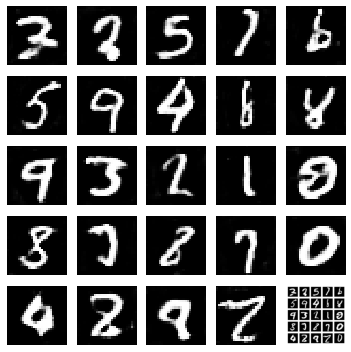

100%|██████████| 350/350 [00:18<00:00, 19.34it/s]


Epoch number: 41 discriminator_loss: 0.6483192152636392 generator_loss: 0.9930052142483847


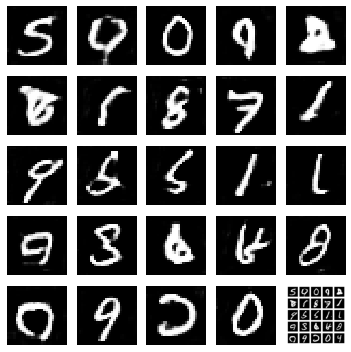

100%|██████████| 350/350 [00:18<00:00, 19.36it/s]


Epoch number: 42 discriminator_loss: 0.6465471042905535 generator_loss: 0.9978109087262835


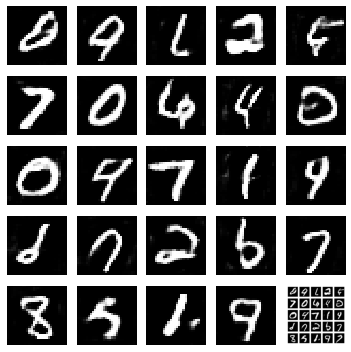

100%|██████████| 350/350 [00:18<00:00, 19.24it/s]


Epoch number: 43 discriminator_loss: 0.6447781074047089 generator_loss: 1.0079971189158303


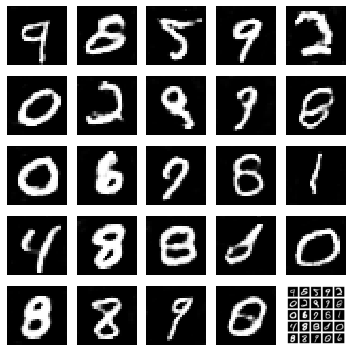

100%|██████████| 350/350 [00:18<00:00, 19.26it/s]


Epoch number: 44 discriminator_loss: 0.642791679756982 generator_loss: 1.0183126759529113


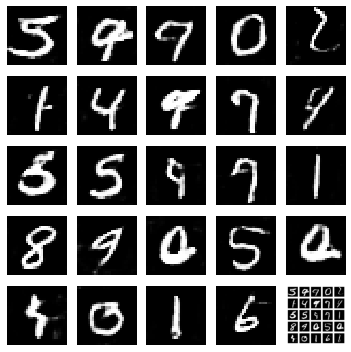

100%|██████████| 350/350 [00:18<00:00, 19.27it/s]


Epoch number: 45 discriminator_loss: 0.641245607989175 generator_loss: 1.0261680572373526


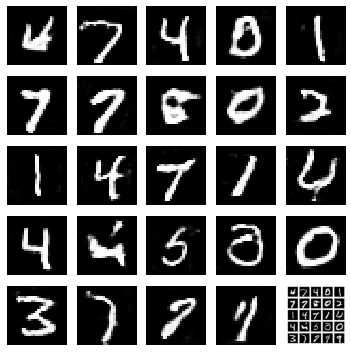

100%|██████████| 350/350 [00:18<00:00, 19.19it/s]


Epoch number: 46 discriminator_loss: 0.6409484037331172 generator_loss: 1.0326907077857426


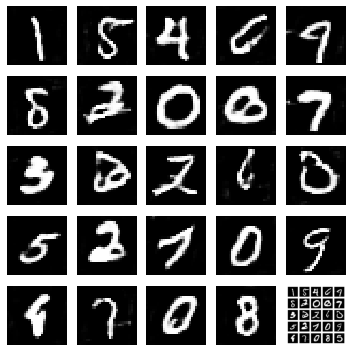

100%|██████████| 350/350 [00:18<00:00, 19.23it/s]


Epoch number: 47 discriminator_loss: 0.6381197507040841 generator_loss: 1.0417224158559526


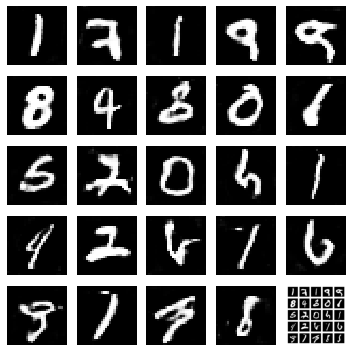

100%|██████████| 350/350 [00:18<00:00, 19.22it/s]


Epoch number: 48 discriminator_loss: 0.6364387539454869 generator_loss: 1.0493898621627262


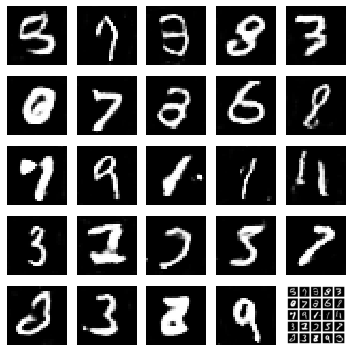

100%|██████████| 350/350 [00:18<00:00, 18.88it/s]


Epoch number: 49 discriminator_loss: 0.6347120812961033 generator_loss: 1.0601827463081905


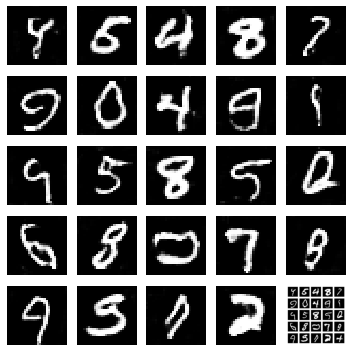

100%|██████████| 350/350 [00:18<00:00, 18.90it/s]


Epoch number: 50 discriminator_loss: 0.63246010524886 generator_loss: 1.0686280035972595


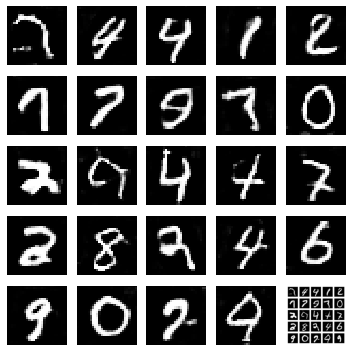

100%|██████████| 350/350 [00:18<00:00, 19.16it/s]


Epoch number: 51 discriminator_loss: 0.630284434386662 generator_loss: 1.0775217301504953


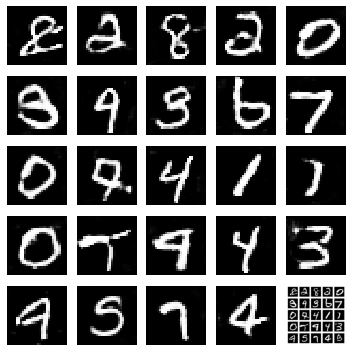

100%|██████████| 350/350 [00:18<00:00, 19.20it/s]


Epoch number: 52 discriminator_loss: 0.6282278427055904 generator_loss: 1.0882828623907908


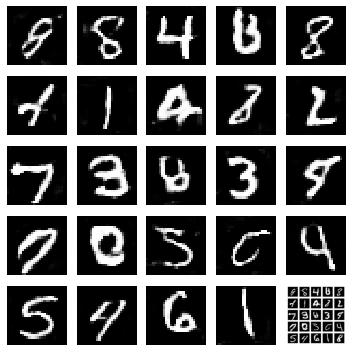

100%|██████████| 350/350 [00:18<00:00, 19.25it/s]


Epoch number: 53 discriminator_loss: 0.6256649647440229 generator_loss: 1.1006496807507107


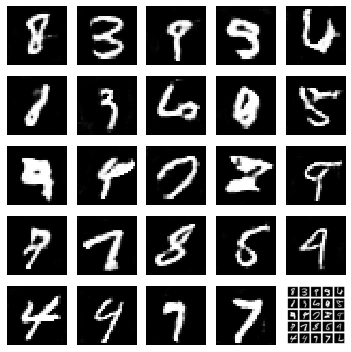

100%|██████████| 350/350 [00:18<00:00, 18.93it/s]


Epoch number: 54 discriminator_loss: 0.6235000962870462 generator_loss: 1.108301225730351


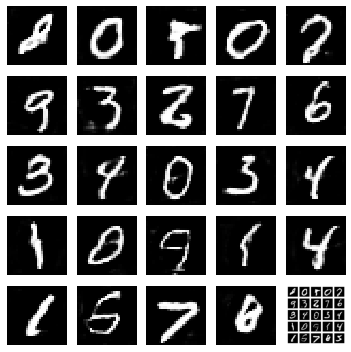

100%|██████████| 350/350 [00:18<00:00, 19.55it/s]


Epoch number: 55 discriminator_loss: 0.6226272329262325 generator_loss: 1.1201568017687116


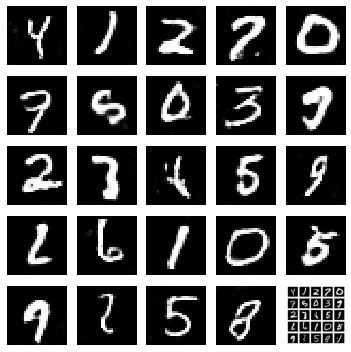

100%|██████████| 350/350 [00:18<00:00, 19.09it/s]


Epoch number: 56 discriminator_loss: 0.6210404646396637 generator_loss: 1.1280738707951137


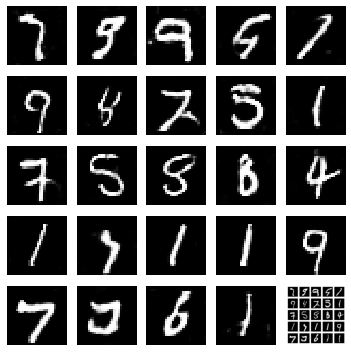

100%|██████████| 350/350 [00:18<00:00, 19.23it/s]


Epoch number: 57 discriminator_loss: 0.6160635110310145 generator_loss: 1.1438645911216736


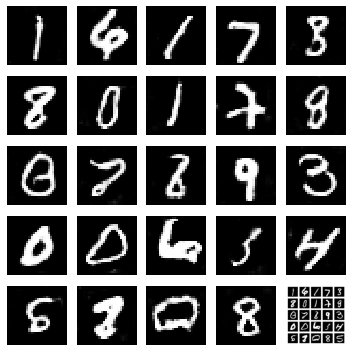

100%|██████████| 350/350 [00:18<00:00, 18.70it/s]


Epoch number: 58 discriminator_loss: 0.6153764871188573 generator_loss: 1.1523659910474504


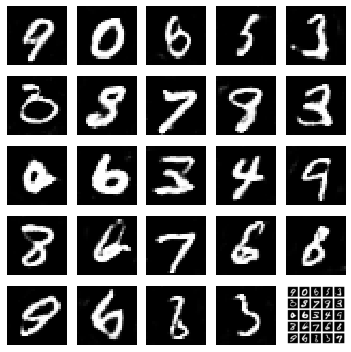

100%|██████████| 350/350 [00:18<00:00, 19.56it/s]


Epoch number: 59 discriminator_loss: 0.6134063879081181 generator_loss: 1.163021616595132


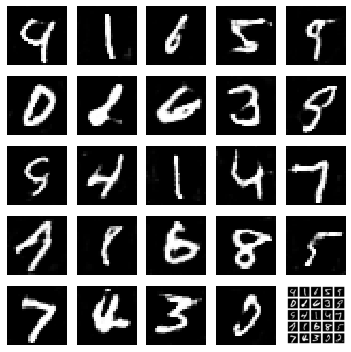

100%|██████████| 350/350 [00:18<00:00, 19.09it/s]


Epoch number: 60 discriminator_loss: 0.6127952737467629 generator_loss: 1.1714798358508518


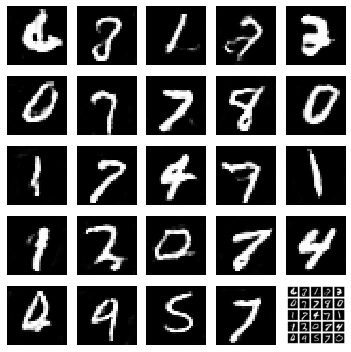

100%|██████████| 350/350 [00:18<00:00, 19.27it/s]


Epoch number: 61 discriminator_loss: 0.6108237755298614 generator_loss: 1.1803777456283568


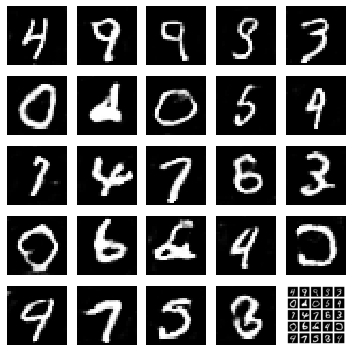

100%|██████████| 350/350 [00:18<00:00, 19.05it/s]


Epoch number: 62 discriminator_loss: 0.6087516590527126 generator_loss: 1.1918301704951695


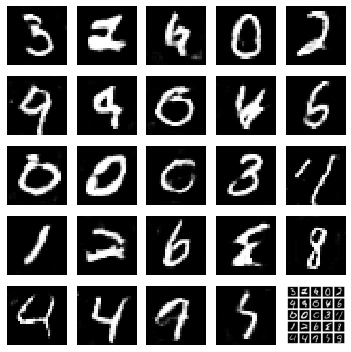

100%|██████████| 350/350 [00:18<00:00, 19.17it/s]


Epoch number: 63 discriminator_loss: 0.6074179989950997 generator_loss: 1.2012627751486642


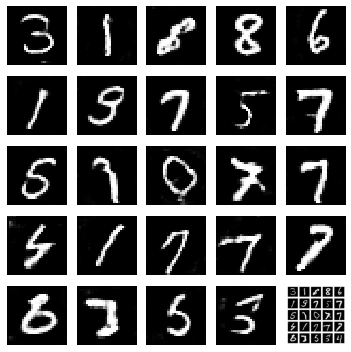

100%|██████████| 350/350 [00:18<00:00, 19.19it/s]


Epoch number: 64 discriminator_loss: 0.6047172388008663 generator_loss: 1.2133061109270369


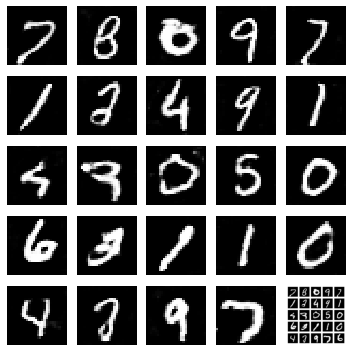

100%|██████████| 350/350 [00:18<00:00, 19.79it/s]


Epoch number: 65 discriminator_loss: 0.6039190069266728 generator_loss: 1.2198886486462184


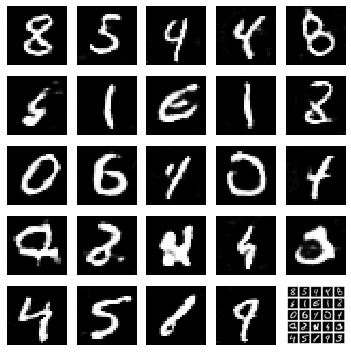

100%|██████████| 350/350 [00:18<00:00, 18.93it/s]


Epoch number: 66 discriminator_loss: 0.6010891732147762 generator_loss: 1.2300779233660017


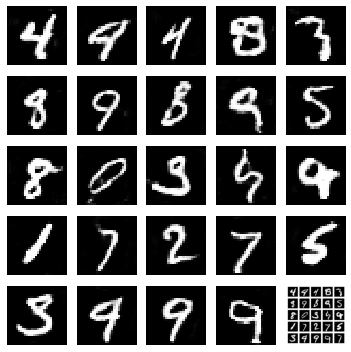

100%|██████████| 350/350 [00:18<00:00, 19.16it/s]


Epoch number: 67 discriminator_loss: 0.599689861025129 generator_loss: 1.244086297920772


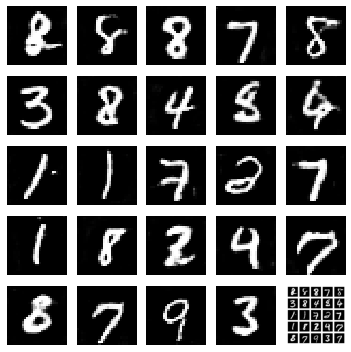

100%|██████████| 350/350 [00:18<00:00, 19.35it/s]


Epoch number: 68 discriminator_loss: 0.5977480304241181 generator_loss: 1.2557027837208339


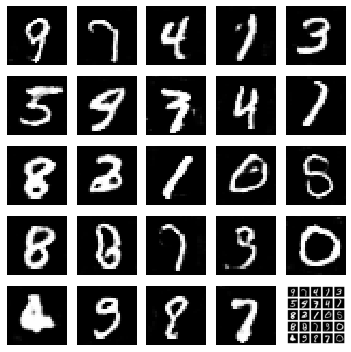

100%|██████████| 350/350 [00:18<00:00, 19.24it/s]


Epoch number: 69 discriminator_loss: 0.593480053969792 generator_loss: 1.2684469873564583


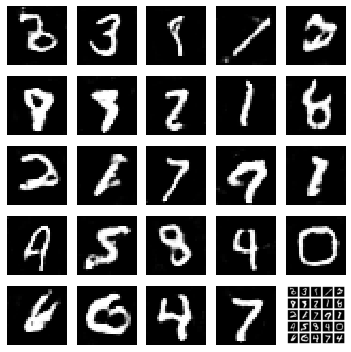

100%|██████████| 350/350 [00:18<00:00, 19.31it/s]


Epoch number: 70 discriminator_loss: 0.5952457863943917 generator_loss: 1.2771373874800547


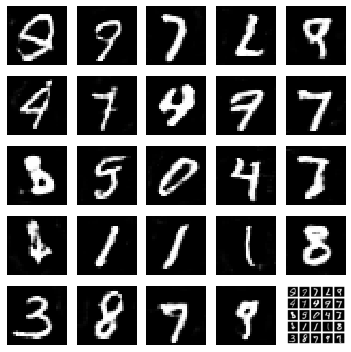

100%|██████████| 350/350 [00:18<00:00, 19.04it/s]


Epoch number: 71 discriminator_loss: 0.5913198498317174 generator_loss: 1.2846683273996626


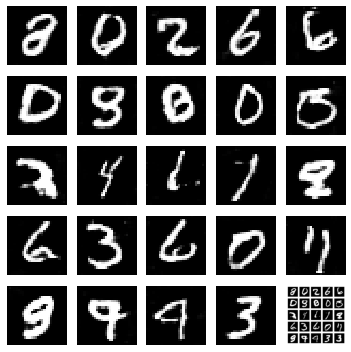

100%|██████████| 350/350 [00:18<00:00, 19.08it/s]


Epoch number: 72 discriminator_loss: 0.5890039883341108 generator_loss: 1.2967858031817845


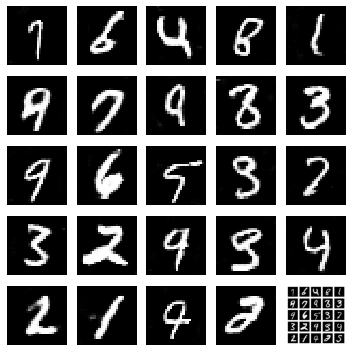

100%|██████████| 350/350 [00:18<00:00, 19.14it/s]


Epoch number: 73 discriminator_loss: 0.5873494299820491 generator_loss: 1.3100873933519637


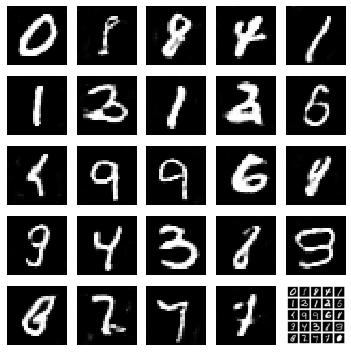

100%|██████████| 350/350 [00:18<00:00, 19.29it/s]


Epoch number: 74 discriminator_loss: 0.587203345639365 generator_loss: 1.317462501185281


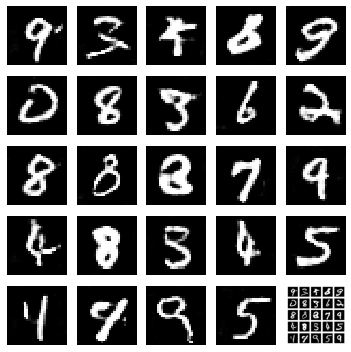

100%|██████████| 350/350 [00:18<00:00, 19.17it/s]


Epoch number: 75 discriminator_loss: 0.5848254288945879 generator_loss: 1.3248333944593158


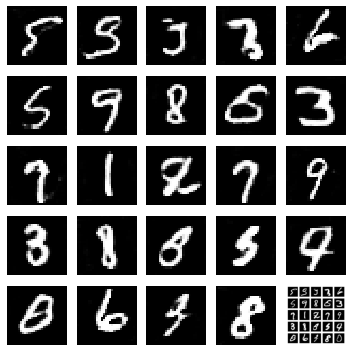

100%|██████████| 350/350 [00:18<00:00, 19.23it/s]


Epoch number: 76 discriminator_loss: 0.5836843136378697 generator_loss: 1.3421192955970764


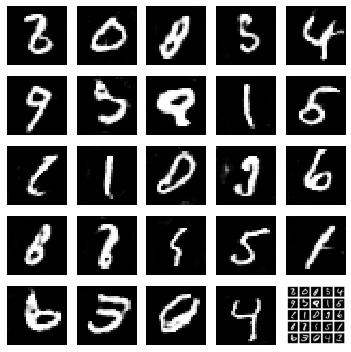

100%|██████████| 350/350 [00:18<00:00, 19.26it/s]


Epoch number: 77 discriminator_loss: 0.5842265820503235 generator_loss: 1.3475984059061323


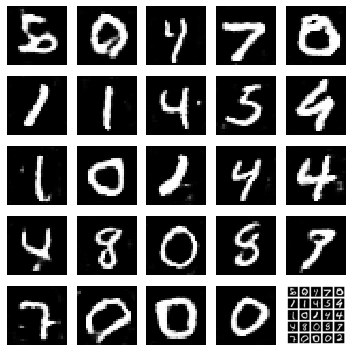

100%|██████████| 350/350 [00:18<00:00, 19.43it/s]


Epoch number: 78 discriminator_loss: 0.5813143949849265 generator_loss: 1.3512086057662964


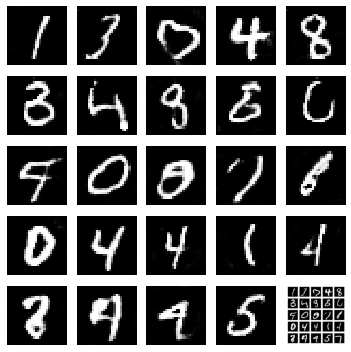

100%|██████████| 350/350 [00:18<00:00, 19.26it/s]


Epoch number: 79 discriminator_loss: 0.5775501423222678 generator_loss: 1.3700532371657235


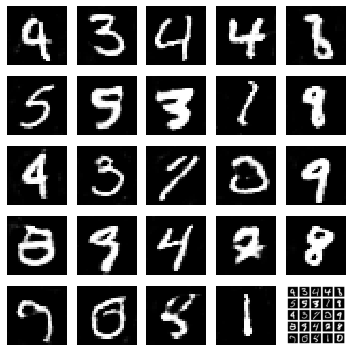

100%|██████████| 350/350 [00:18<00:00, 19.26it/s]


Epoch number: 80 discriminator_loss: 0.5771212874140058 generator_loss: 1.3803780695370265


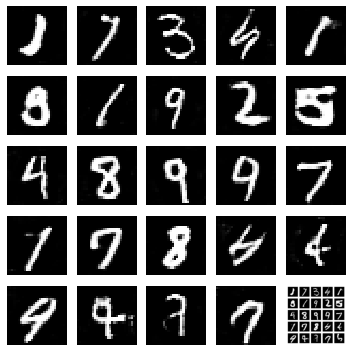

100%|██████████| 350/350 [00:18<00:00, 19.31it/s]


Epoch number: 81 discriminator_loss: 0.5745241611344474 generator_loss: 1.3863471831594194


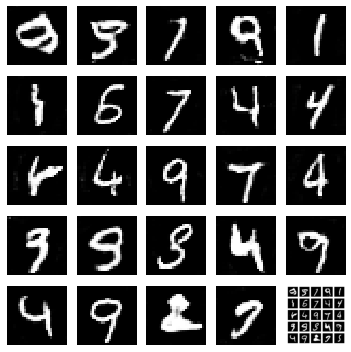

100%|██████████| 350/350 [00:18<00:00, 18.96it/s]


Epoch number: 82 discriminator_loss: 0.5757946172782353 generator_loss: 1.4001290937832425


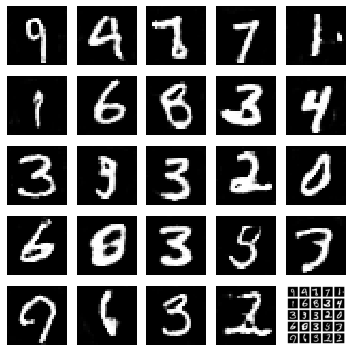

100%|██████████| 350/350 [00:18<00:00, 19.49it/s]


Epoch number: 83 discriminator_loss: 0.5733422788551875 generator_loss: 1.4049154101099286


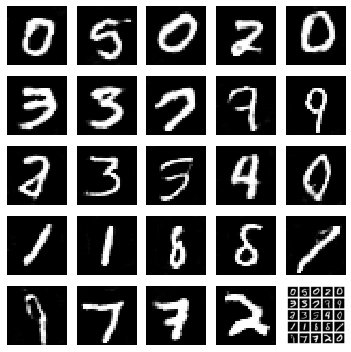

100%|██████████| 350/350 [00:18<00:00, 19.41it/s]


Epoch number: 84 discriminator_loss: 0.5690571698120662 generator_loss: 1.4159462526866369


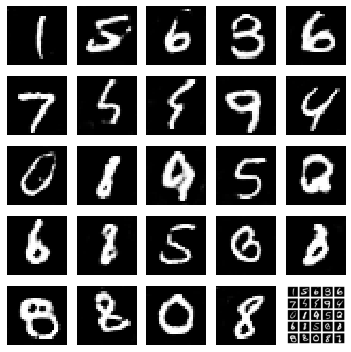

100%|██████████| 350/350 [00:18<00:00, 19.28it/s]


Epoch number: 85 discriminator_loss: 0.5718167088712964 generator_loss: 1.4266236172403608


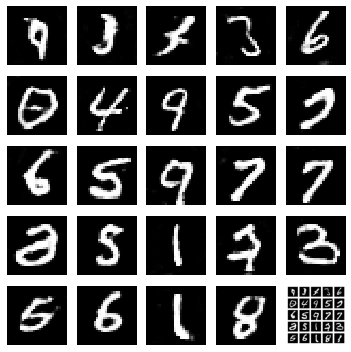

100%|██████████| 350/350 [00:17<00:00, 19.39it/s]


Epoch number: 86 discriminator_loss: 0.5678040180887495 generator_loss: 1.4378355353219168


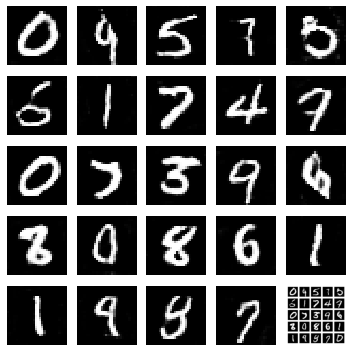

100%|██████████| 350/350 [00:18<00:00, 19.73it/s]


Epoch number: 87 discriminator_loss: 0.5658964036192213 generator_loss: 1.4407782646587917


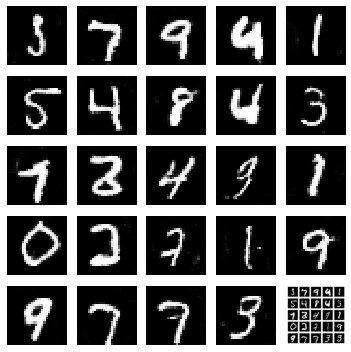

100%|██████████| 350/350 [00:18<00:00, 19.43it/s]


Epoch number: 88 discriminator_loss: 0.565490790946143 generator_loss: 1.4562845955576216


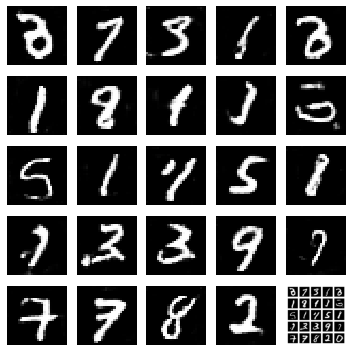

100%|██████████| 350/350 [00:18<00:00, 19.46it/s]


Epoch number: 89 discriminator_loss: 0.5644231583390917 generator_loss: 1.4557907332692828


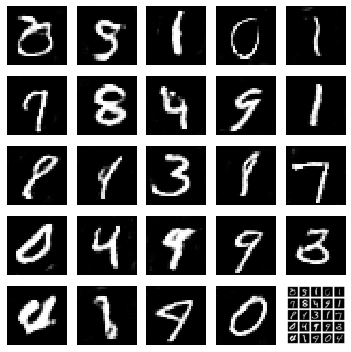

100%|██████████| 350/350 [00:17<00:00, 19.45it/s]


Epoch number: 90 discriminator_loss: 0.5646951075962612 generator_loss: 1.4724337138448442


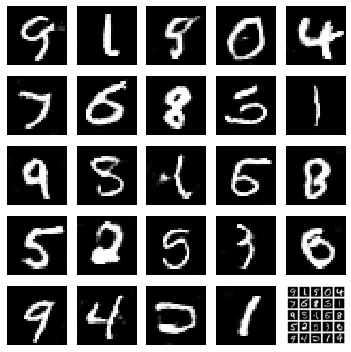

100%|██████████| 350/350 [00:17<00:00, 19.65it/s]


Epoch number: 91 discriminator_loss: 0.5627938423837934 generator_loss: 1.4761866899899074


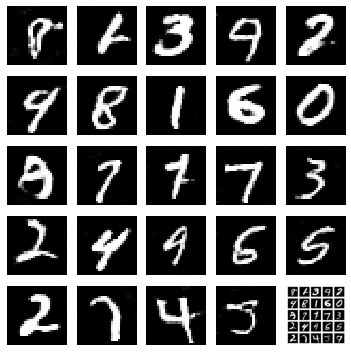

100%|██████████| 350/350 [00:17<00:00, 19.72it/s]


Epoch number: 92 discriminator_loss: 0.5611762931517192 generator_loss: 1.4849030722890582


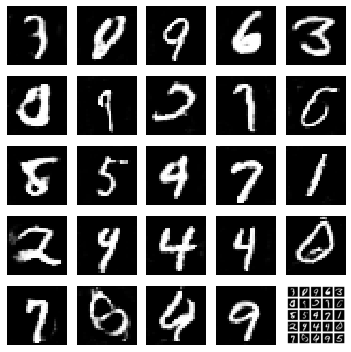

100%|██████████| 350/350 [00:18<00:00, 19.47it/s]


Epoch number: 93 discriminator_loss: 0.5586711594888142 generator_loss: 1.4975085817064557


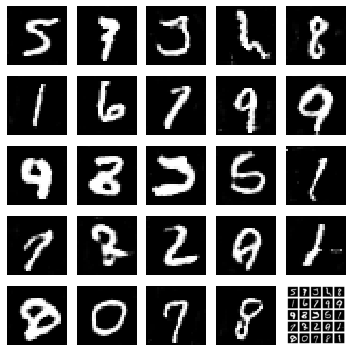

100%|██████████| 350/350 [00:17<00:00, 19.56it/s]


Epoch number: 94 discriminator_loss: 0.5582379191262381 generator_loss: 1.5011393111092703


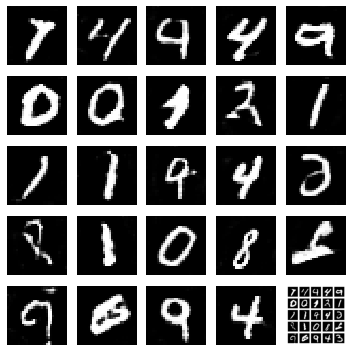

100%|██████████| 350/350 [00:19<00:00, 18.34it/s]


Epoch number: 95 discriminator_loss: 0.5563064620324544 generator_loss: 1.5116631838253567


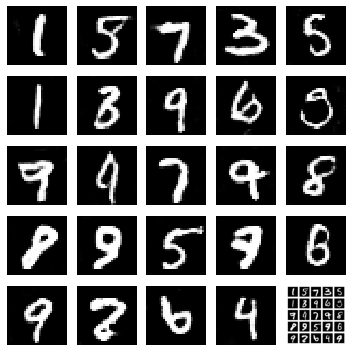

100%|██████████| 350/350 [00:18<00:00, 19.46it/s]


Epoch number: 96 discriminator_loss: 0.5573334545748574 generator_loss: 1.5158445044926234


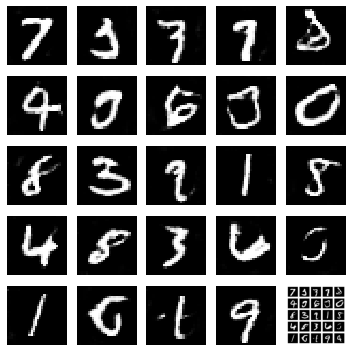

100%|██████████| 350/350 [00:18<00:00, 19.13it/s]


Epoch number: 97 discriminator_loss: 0.5557141355105809 generator_loss: 1.5187943066869463


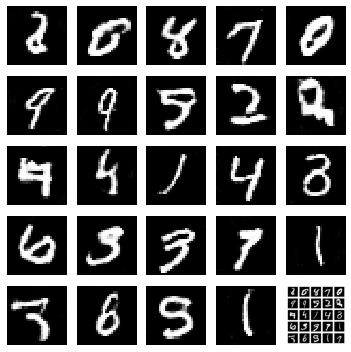

100%|██████████| 350/350 [00:18<00:00, 19.39it/s]


Epoch number: 98 discriminator_loss: 0.5554626204286303 generator_loss: 1.5325294518470765


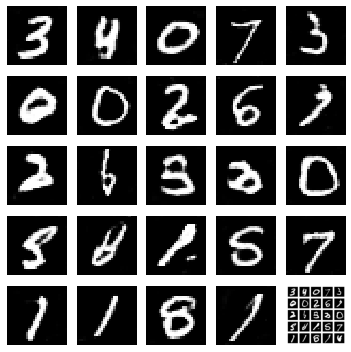

100%|██████████| 350/350 [00:18<00:00, 18.37it/s]


Epoch number: 99 discriminator_loss: 0.5532516575711114 generator_loss: 1.543322092464992


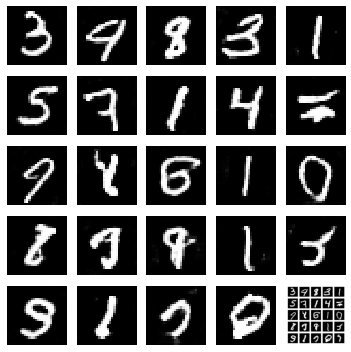

100%|██████████| 350/350 [00:18<00:00, 19.14it/s]


Epoch number: 100 discriminator_loss: 0.5505030722277505 generator_loss: 1.5452270473752703


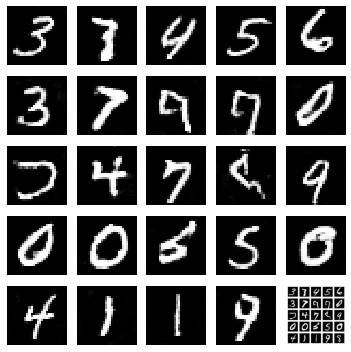

100%|██████████| 350/350 [00:18<00:00, 18.68it/s]


Epoch number: 101 discriminator_loss: 0.5496132852349962 generator_loss: 1.5577788598196847


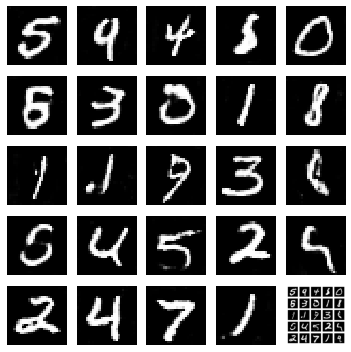

100%|██████████| 350/350 [00:18<00:00, 18.77it/s]


Epoch number: 102 discriminator_loss: 0.546619537302426 generator_loss: 1.5755568507739475


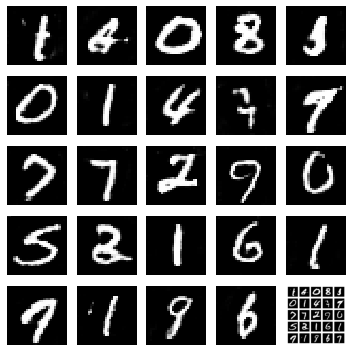

100%|██████████| 350/350 [00:18<00:00, 19.24it/s]


Epoch number: 103 discriminator_loss: 0.5464196536370686 generator_loss: 1.5795168563297817


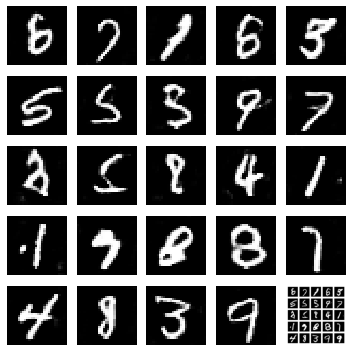

100%|██████████| 350/350 [00:18<00:00, 18.87it/s]


Epoch number: 104 discriminator_loss: 0.545082637837955 generator_loss: 1.583010036604745


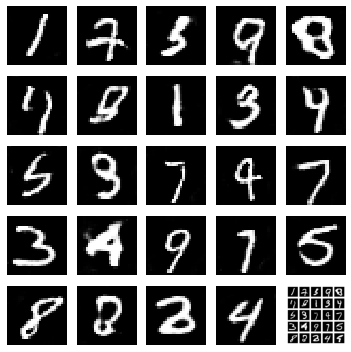

100%|██████████| 350/350 [00:18<00:00, 18.65it/s]


Epoch number: 105 discriminator_loss: 0.5475571816308158 generator_loss: 1.5939250799587794


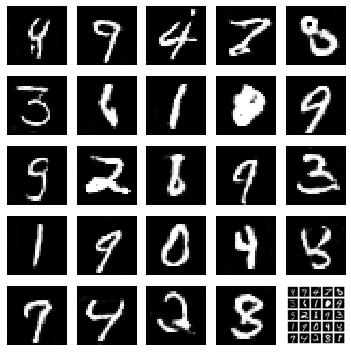

100%|██████████| 350/350 [00:18<00:00, 19.23it/s]


Epoch number: 106 discriminator_loss: 0.5458637412956783 generator_loss: 1.587790949004037


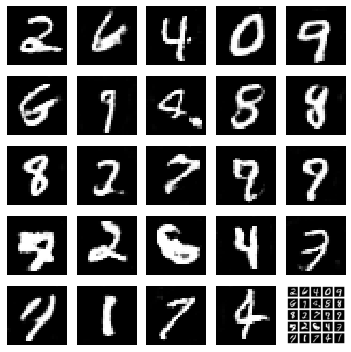

100%|██████████| 350/350 [00:18<00:00, 18.92it/s]


Epoch number: 107 discriminator_loss: 0.543448543548584 generator_loss: 1.601566389969417


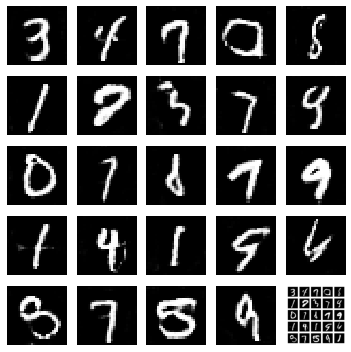

100%|██████████| 350/350 [00:18<00:00, 18.94it/s]


Epoch number: 108 discriminator_loss: 0.5433520256621497 generator_loss: 1.6126680088043213


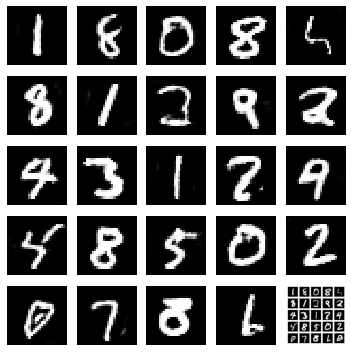

100%|██████████| 350/350 [00:18<00:00, 18.77it/s]


Epoch number: 109 discriminator_loss: 0.5404240079436984 generator_loss: 1.6170424437522888


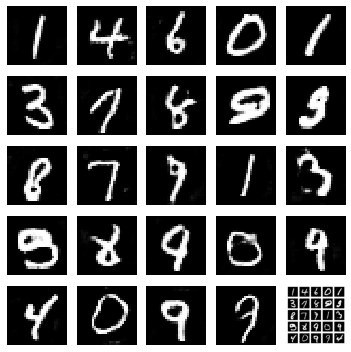

100%|██████████| 350/350 [00:18<00:00, 18.13it/s]


Epoch number: 110 discriminator_loss: 0.5397979100261415 generator_loss: 1.629974251134055


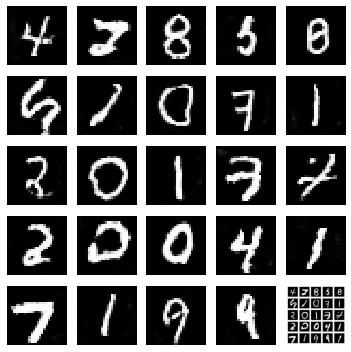

100%|██████████| 350/350 [00:18<00:00, 19.14it/s]


Epoch number: 111 discriminator_loss: 0.540668528676033 generator_loss: 1.6302344918251037


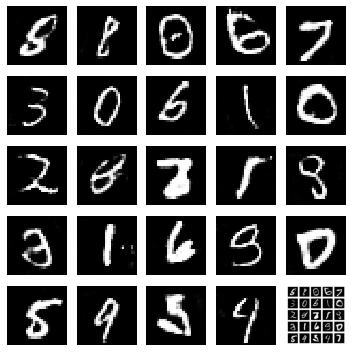

100%|██████████| 350/350 [00:18<00:00, 19.06it/s]


Epoch number: 112 discriminator_loss: 0.5373071111951555 generator_loss: 1.645296427181789


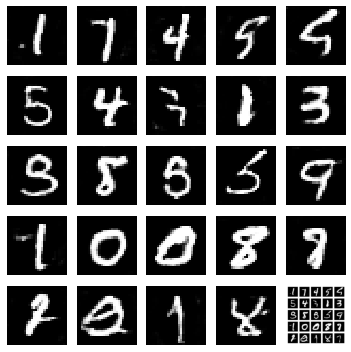

100%|██████████| 350/350 [00:18<00:00, 19.25it/s]


Epoch number: 113 discriminator_loss: 0.5394286856481008 generator_loss: 1.649765794958387


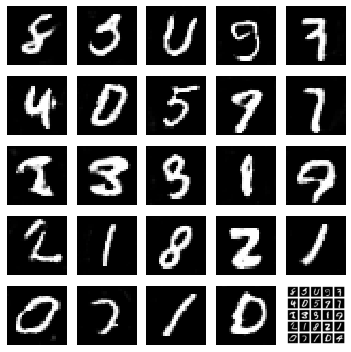

100%|██████████| 350/350 [00:18<00:00, 19.45it/s]


Epoch number: 114 discriminator_loss: 0.5391367667061941 generator_loss: 1.6533295597348894


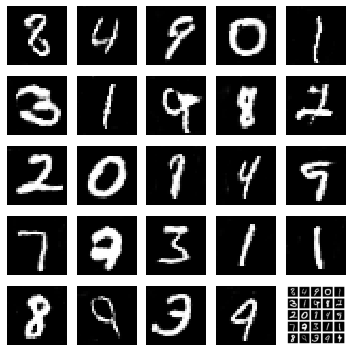

100%|██████████| 350/350 [00:18<00:00, 19.53it/s]


Epoch number: 115 discriminator_loss: 0.5368966223512377 generator_loss: 1.6530067603928702


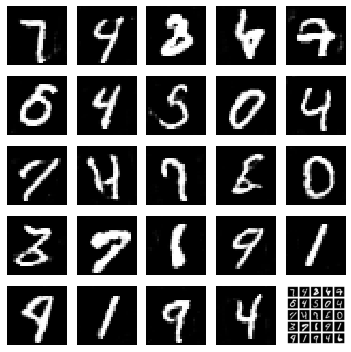

100%|██████████| 350/350 [00:18<00:00, 19.65it/s]


Epoch number: 116 discriminator_loss: 0.5338453963824681 generator_loss: 1.6667792579105922


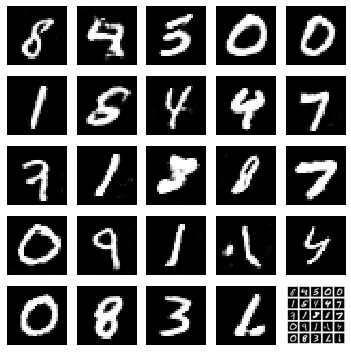

100%|██████████| 350/350 [00:17<00:00, 19.46it/s]


Epoch number: 117 discriminator_loss: 0.5319667588812964 generator_loss: 1.6763912619863237


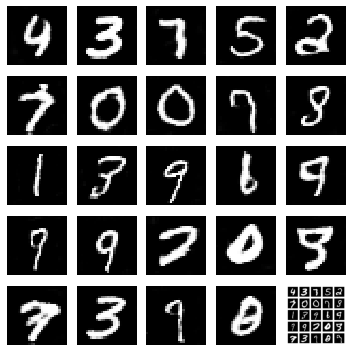

100%|██████████| 350/350 [00:17<00:00, 19.57it/s]


Epoch number: 118 discriminator_loss: 0.531267917241369 generator_loss: 1.6799781165804182


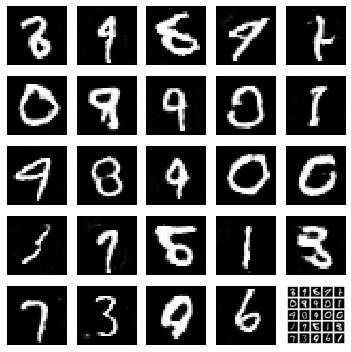

100%|██████████| 350/350 [00:18<00:00, 19.35it/s]


Epoch number: 119 discriminator_loss: 0.534889286330768 generator_loss: 1.68675420829228


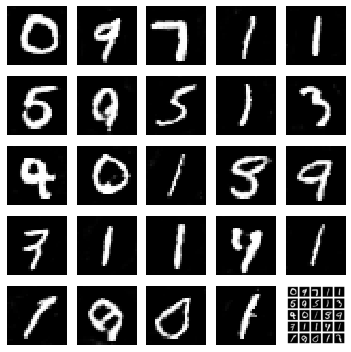

100%|██████████| 350/350 [00:17<00:00, 19.45it/s]


Epoch number: 120 discriminator_loss: 0.5323508638143539 generator_loss: 1.698205098084041


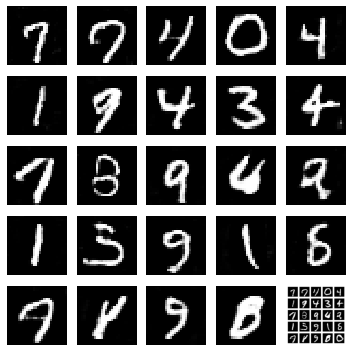

100%|██████████| 350/350 [00:18<00:00, 19.19it/s]


Epoch number: 121 discriminator_loss: 0.5307748079299927 generator_loss: 1.6968092846870422


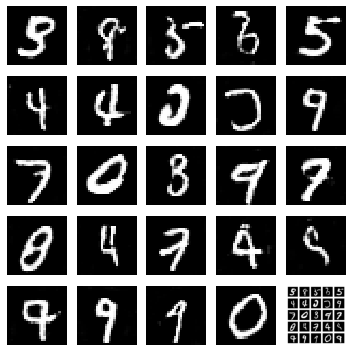

100%|██████████| 350/350 [00:18<00:00, 19.38it/s]


Epoch number: 122 discriminator_loss: 0.5284230245011193 generator_loss: 1.700570948805128


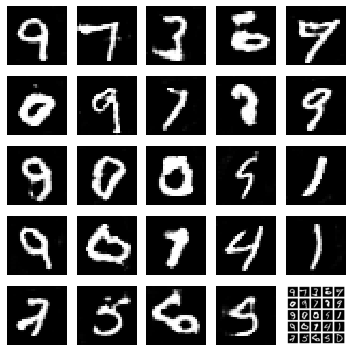

100%|██████████| 350/350 [00:17<00:00, 19.39it/s]


Epoch number: 123 discriminator_loss: 0.5280924798761095 generator_loss: 1.7115126044409616


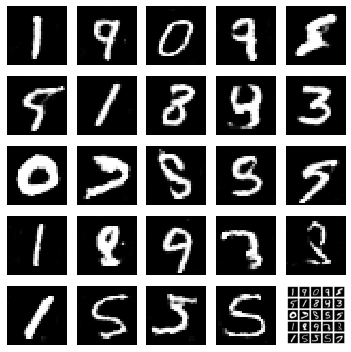

100%|██████████| 350/350 [00:18<00:00, 19.41it/s]


Epoch number: 124 discriminator_loss: 0.5274820181301662 generator_loss: 1.7151736102785382


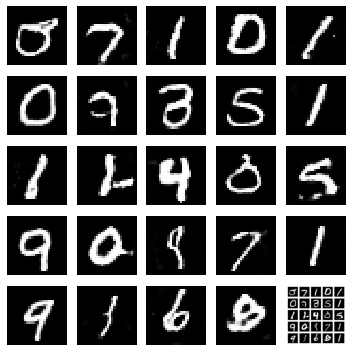

100%|██████████| 350/350 [00:17<00:00, 19.45it/s]


Epoch number: 125 discriminator_loss: 0.526306357554027 generator_loss: 1.721323447227478


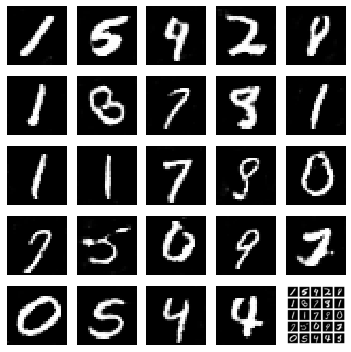

100%|██████████| 350/350 [00:17<00:00, 19.45it/s]


Epoch number: 126 discriminator_loss: 0.5241566913468497 generator_loss: 1.7250552834783281


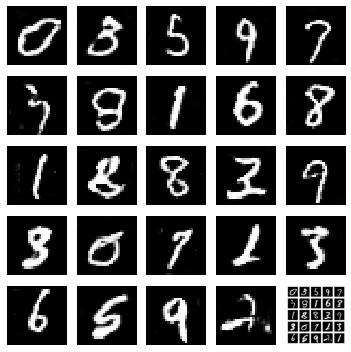

100%|██████████| 350/350 [00:18<00:00, 19.40it/s]


Epoch number: 127 discriminator_loss: 0.524205384850502 generator_loss: 1.7394482513836451


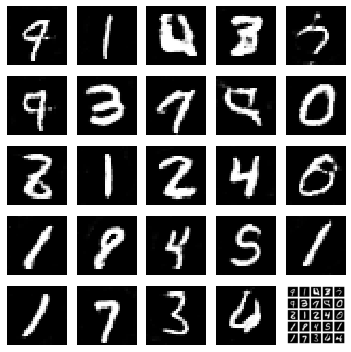

100%|██████████| 350/350 [00:18<00:00, 19.39it/s]


Epoch number: 128 discriminator_loss: 0.5252388701268604 generator_loss: 1.738867553983416


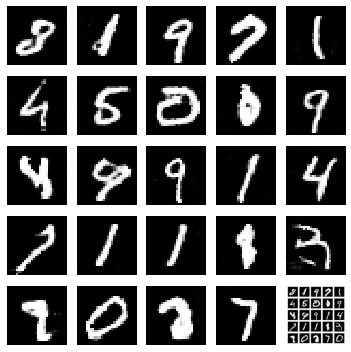

100%|██████████| 350/350 [00:18<00:00, 19.19it/s]


Epoch number: 129 discriminator_loss: 0.5224065051759992 generator_loss: 1.7399544368471418


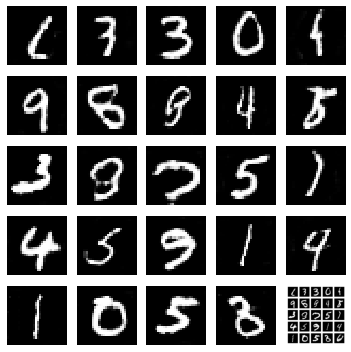

100%|██████████| 350/350 [00:17<00:00, 19.51it/s]


Epoch number: 130 discriminator_loss: 0.5223625648873192 generator_loss: 1.7455679777690343


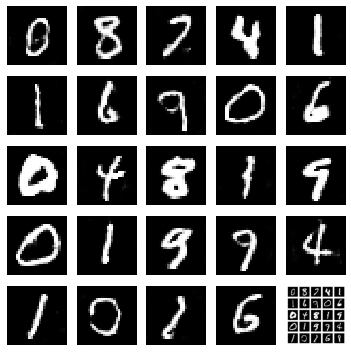

100%|██████████| 350/350 [00:17<00:00, 19.51it/s]


Epoch number: 131 discriminator_loss: 0.5223796035562243 generator_loss: 1.759838557583945


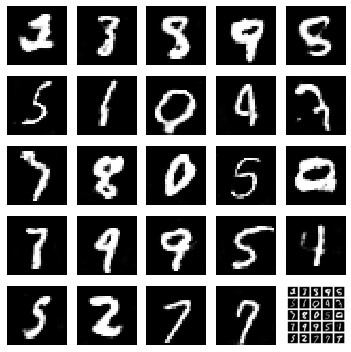

100%|██████████| 350/350 [00:18<00:00, 19.43it/s]


Epoch number: 132 discriminator_loss: 0.5210040536948612 generator_loss: 1.767236067908151


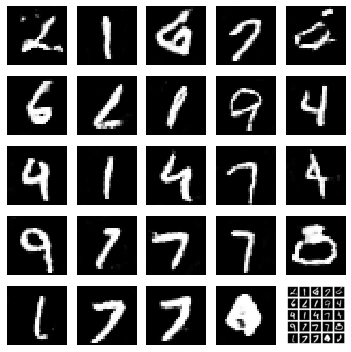

100%|██████████| 350/350 [00:18<00:00, 19.38it/s]


Epoch number: 133 discriminator_loss: 0.5199422280277525 generator_loss: 1.7624317359924317


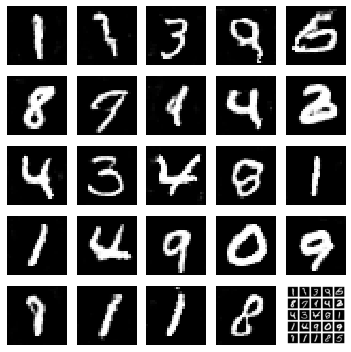

100%|██████████| 350/350 [00:18<00:00, 19.36it/s]


Epoch number: 134 discriminator_loss: 0.5202482246501106 generator_loss: 1.7713992881774903


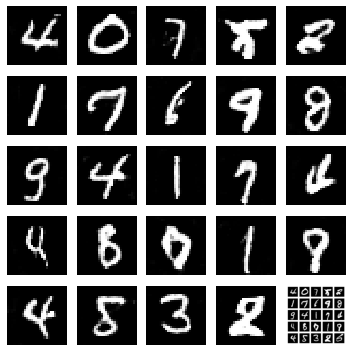

100%|██████████| 350/350 [00:18<00:00, 19.26it/s]


Epoch number: 135 discriminator_loss: 0.5192301127740315 generator_loss: 1.776046210357121


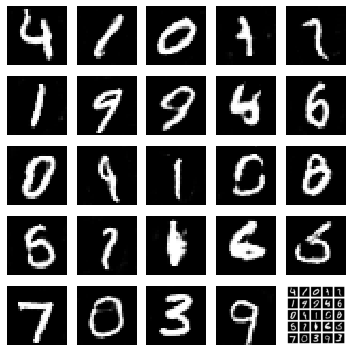

100%|██████████| 350/350 [00:18<00:00, 19.34it/s]


Epoch number: 136 discriminator_loss: 0.517704427923475 generator_loss: 1.7784743687084743


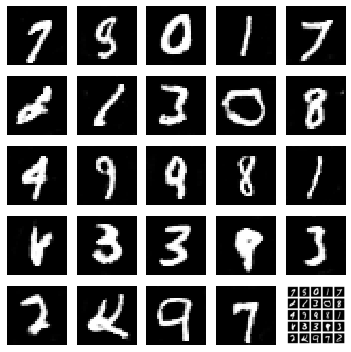

100%|██████████| 350/350 [00:18<00:00, 19.16it/s]


Epoch number: 137 discriminator_loss: 0.5159127139193671 generator_loss: 1.7929503519194467


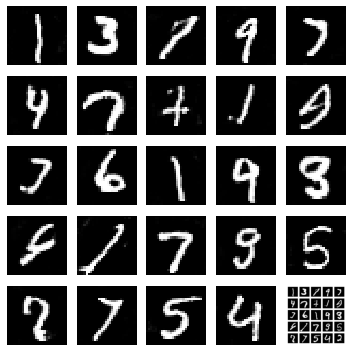

100%|██████████| 350/350 [00:18<00:00, 19.61it/s]


Epoch number: 138 discriminator_loss: 0.5195599967241287 generator_loss: 1.7912895257132393


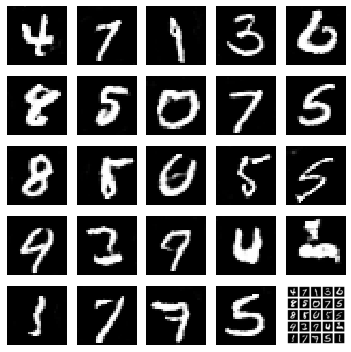

100%|██████████| 350/350 [00:18<00:00, 19.02it/s]


Epoch number: 139 discriminator_loss: 0.5154419973918369 generator_loss: 1.7989828034809658


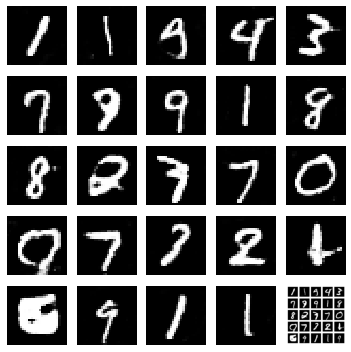

100%|██████████| 350/350 [00:18<00:00, 19.21it/s]


Epoch number: 140 discriminator_loss: 0.5163839651005608 generator_loss: 1.8064141471045359


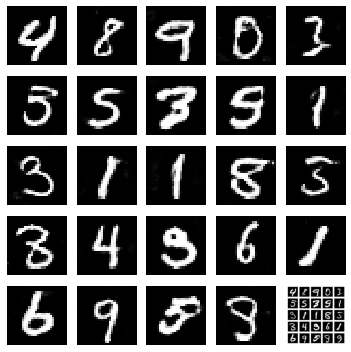

100%|██████████| 350/350 [00:18<00:00, 19.54it/s]


Epoch number: 141 discriminator_loss: 0.5150200952802385 generator_loss: 1.801811477116176


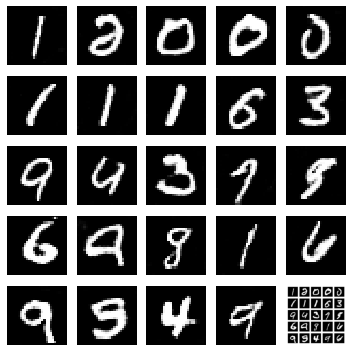

100%|██████████| 350/350 [00:18<00:00, 19.35it/s]


Epoch number: 142 discriminator_loss: 0.5147619502885001 generator_loss: 1.8190710278919764


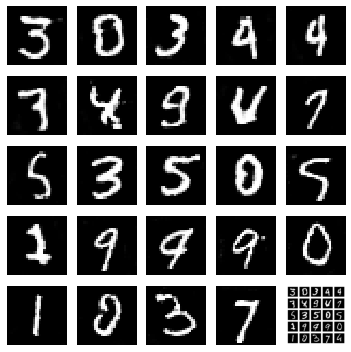

100%|██████████| 350/350 [00:18<00:00, 19.22it/s]


Epoch number: 143 discriminator_loss: 0.5102450200489589 generator_loss: 1.8255526781082154


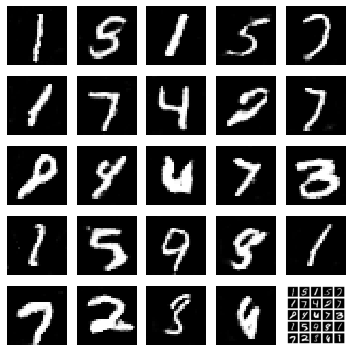

100%|██████████| 350/350 [00:18<00:00, 19.12it/s]


Epoch number: 144 discriminator_loss: 0.5099934523446219 generator_loss: 1.8288186713627406


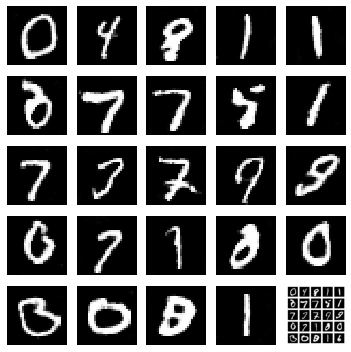

100%|██████████| 350/350 [00:18<00:00, 19.33it/s]


Epoch number: 145 discriminator_loss: 0.5135310224124363 generator_loss: 1.8160652991703579


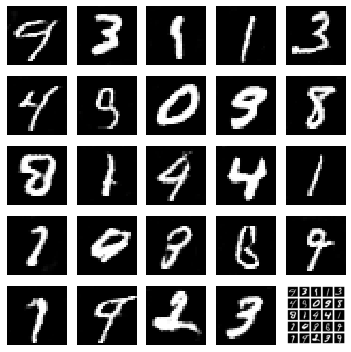

100%|██████████| 350/350 [00:18<00:00, 19.25it/s]


Epoch number: 146 discriminator_loss: 0.5108852227245059 generator_loss: 1.8341074984414236


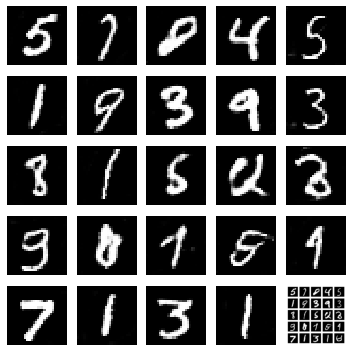

100%|██████████| 350/350 [00:18<00:00, 19.21it/s]


Epoch number: 147 discriminator_loss: 0.5119465737683433 generator_loss: 1.8606340180124554


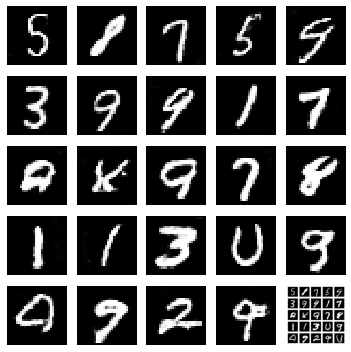

100%|██████████| 350/350 [00:18<00:00, 19.14it/s]


Epoch number: 148 discriminator_loss: 0.5103312760591507 generator_loss: 1.8428080821037292


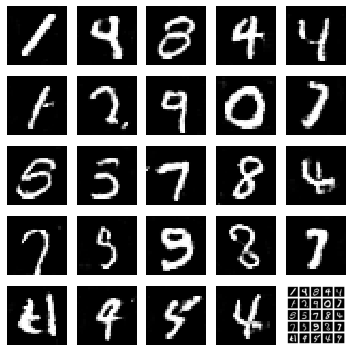

100%|██████████| 350/350 [00:18<00:00, 19.19it/s]


Epoch number: 149 discriminator_loss: 0.508424945303372 generator_loss: 1.8522146596227373


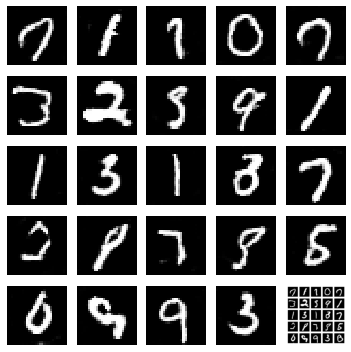

100%|██████████| 350/350 [00:18<00:00, 18.94it/s]


Epoch number: 150 discriminator_loss: 0.5112021281889507 generator_loss: 1.8394565510749816


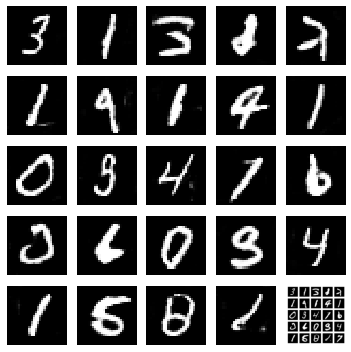

100%|██████████| 350/350 [00:18<00:00, 19.16it/s]


Epoch number: 151 discriminator_loss: 0.5098556429999215 generator_loss: 1.8423863468851363


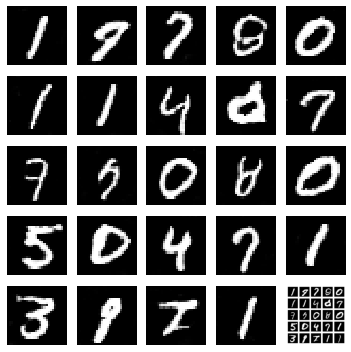

100%|██████████| 350/350 [00:18<00:00, 19.32it/s]


Epoch number: 152 discriminator_loss: 0.5068025812080929 generator_loss: 1.845284046786172


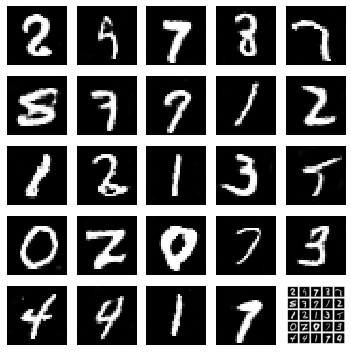

100%|██████████| 350/350 [00:18<00:00, 19.09it/s]


Epoch number: 153 discriminator_loss: 0.508745030420167 generator_loss: 1.8595439515795027


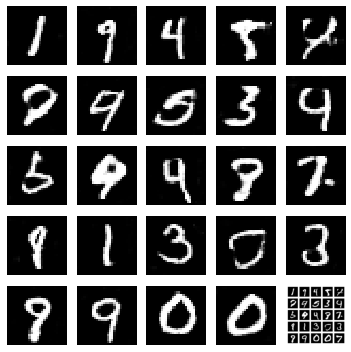

100%|██████████| 350/350 [00:18<00:00, 18.98it/s]


Epoch number: 154 discriminator_loss: 0.503191459264074 generator_loss: 1.864771328994206


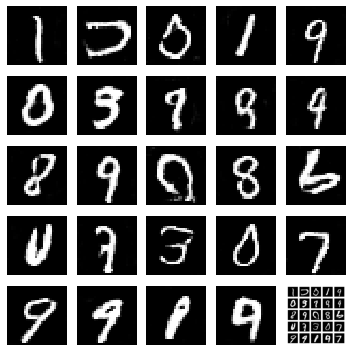

100%|██████████| 350/350 [00:18<00:00, 19.00it/s]


Epoch number: 155 discriminator_loss: 0.5080145231315067 generator_loss: 1.8645295698302133


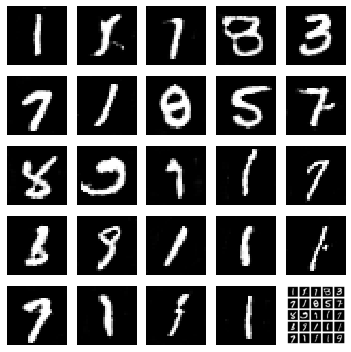

100%|██████████| 350/350 [00:18<00:00, 19.22it/s]


Epoch number: 156 discriminator_loss: 0.5074403932264873 generator_loss: 1.8752771990639823


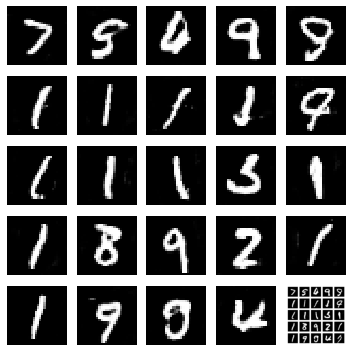

100%|██████████| 350/350 [00:18<00:00, 19.05it/s]


Epoch number: 157 discriminator_loss: 0.5060620054176875 generator_loss: 1.8800580658231463


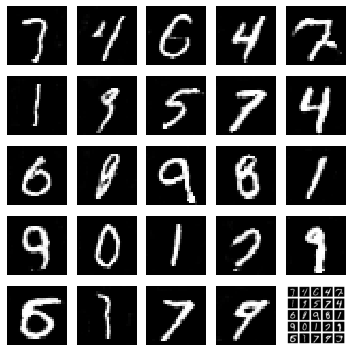

100%|██████████| 350/350 [00:18<00:00, 18.85it/s]


Epoch number: 158 discriminator_loss: 0.5056735424484525 generator_loss: 1.8833034958158221


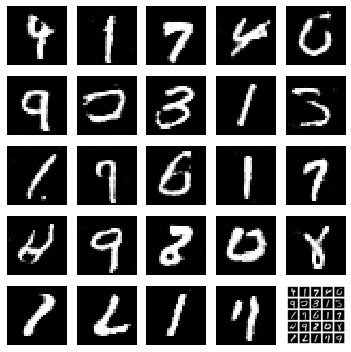

100%|██████████| 350/350 [00:18<00:00, 19.05it/s]


Epoch number: 159 discriminator_loss: 0.5053302447284971 generator_loss: 1.8890325699533734


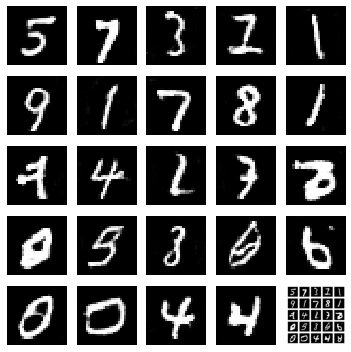

100%|██████████| 350/350 [00:18<00:00, 18.90it/s]


Epoch number: 160 discriminator_loss: 0.5035242282492773 generator_loss: 1.891265892301287


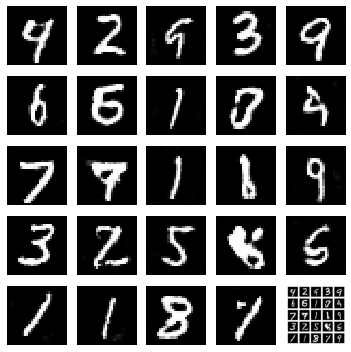

100%|██████████| 350/350 [00:18<00:00, 19.02it/s]


Epoch number: 161 discriminator_loss: 0.5063779824120658 generator_loss: 1.8815200747762408


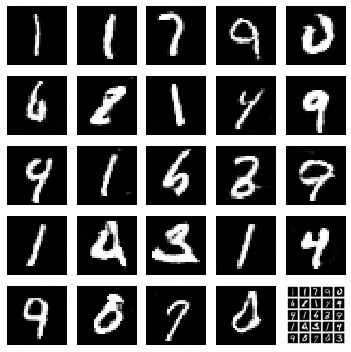

100%|██████████| 350/350 [00:18<00:00, 18.89it/s]


Epoch number: 162 discriminator_loss: 0.5030168388571058 generator_loss: 1.890628776550293


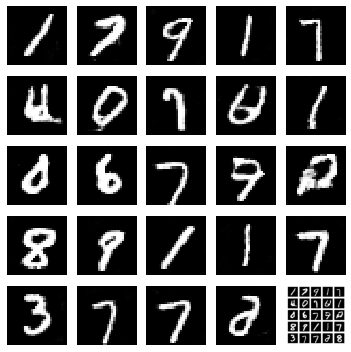

100%|██████████| 350/350 [00:18<00:00, 19.33it/s]


Epoch number: 163 discriminator_loss: 0.5021318650245666 generator_loss: 1.904184205532074


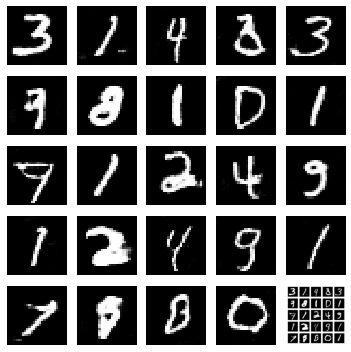

100%|██████████| 350/350 [00:18<00:00, 18.82it/s]


Epoch number: 164 discriminator_loss: 0.5017337042944772 generator_loss: 1.898673108645848


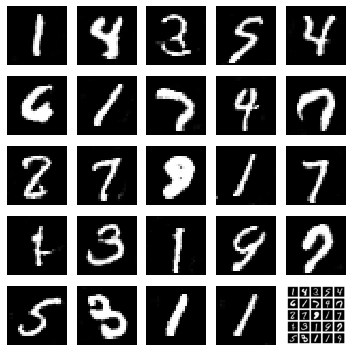

100%|██████████| 350/350 [00:18<00:00, 19.18it/s]


Epoch number: 165 discriminator_loss: 0.5013077563898904 generator_loss: 1.911896378993988


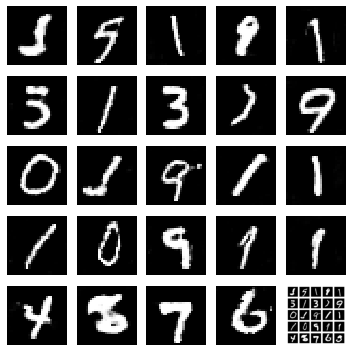

100%|██████████| 350/350 [00:18<00:00, 18.92it/s]


Epoch number: 166 discriminator_loss: 0.4999689677783421 generator_loss: 1.9162083339691163


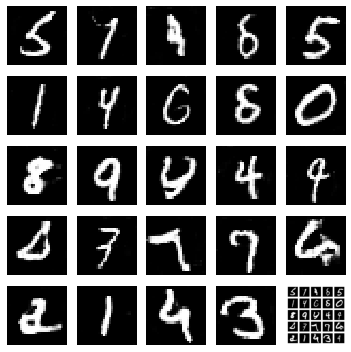

100%|██████████| 350/350 [00:18<00:00, 19.02it/s]


Epoch number: 167 discriminator_loss: 0.4997303527593613 generator_loss: 1.9045580560820443


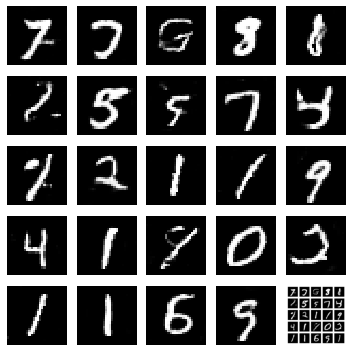

100%|██████████| 350/350 [00:18<00:00, 19.21it/s]


Epoch number: 168 discriminator_loss: 0.4995646743263517 generator_loss: 1.9086141324043273


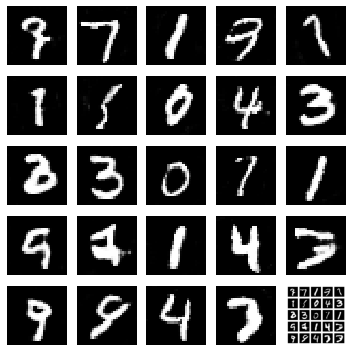

100%|██████████| 350/350 [00:18<00:00, 19.03it/s]


Epoch number: 169 discriminator_loss: 0.49918424887316565 generator_loss: 1.9187639921052115


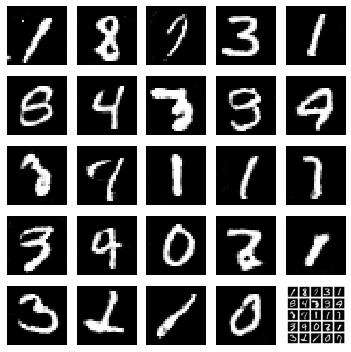

100%|██████████| 350/350 [00:18<00:00, 18.98it/s]


Epoch number: 170 discriminator_loss: 0.49746259348733085 generator_loss: 1.9266048972947256


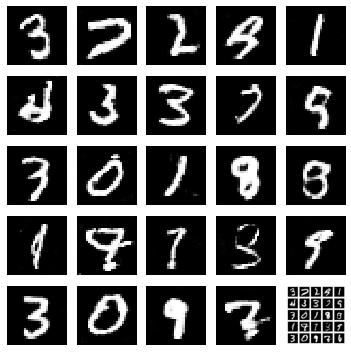

100%|██████████| 350/350 [00:18<00:00, 19.00it/s]


Epoch number: 171 discriminator_loss: 0.4984589074339185 generator_loss: 1.9161305482046944


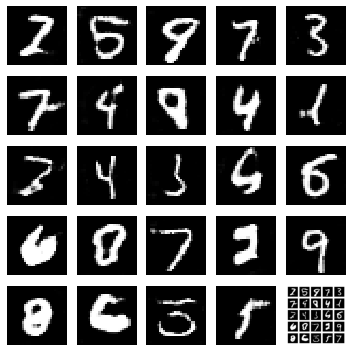

100%|██████████| 350/350 [00:18<00:00, 19.10it/s]


Epoch number: 172 discriminator_loss: 0.5016752455064228 generator_loss: 1.921437520980835


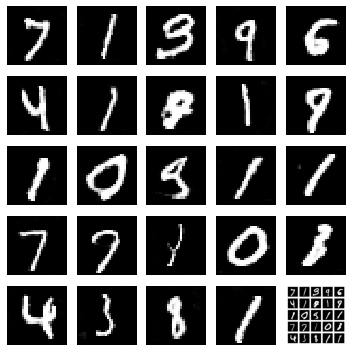

100%|██████████| 350/350 [00:18<00:00, 19.05it/s]


Epoch number: 173 discriminator_loss: 0.49967103038515365 generator_loss: 1.9284965978349957


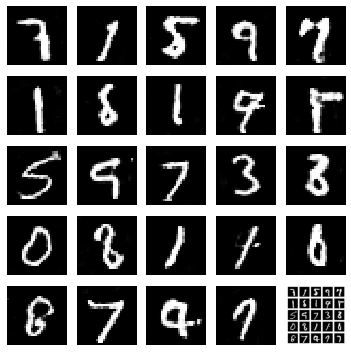

100%|██████████| 350/350 [00:18<00:00, 19.07it/s]


Epoch number: 174 discriminator_loss: 0.49658640350614275 generator_loss: 1.9373283304486957


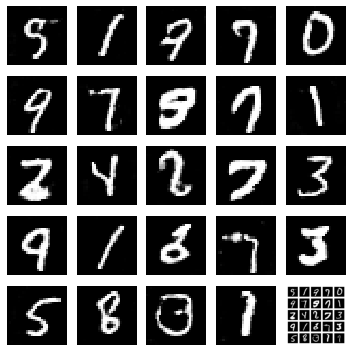

100%|██████████| 350/350 [00:18<00:00, 19.13it/s]


Epoch number: 175 discriminator_loss: 0.4979766308409827 generator_loss: 1.9331994005611965


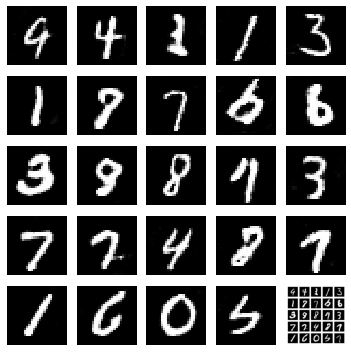

100%|██████████| 350/350 [00:18<00:00, 18.91it/s]


Epoch number: 176 discriminator_loss: 0.4960553529432842 generator_loss: 1.9293634125164576


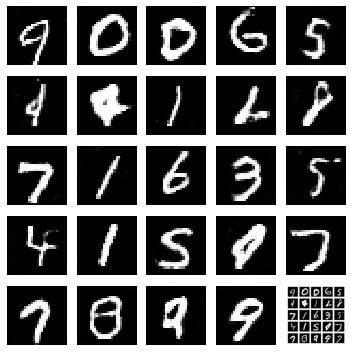

100%|██████████| 350/350 [00:18<00:00, 19.19it/s]


Epoch number: 177 discriminator_loss: 0.49462927613939556 generator_loss: 1.9364658195631845


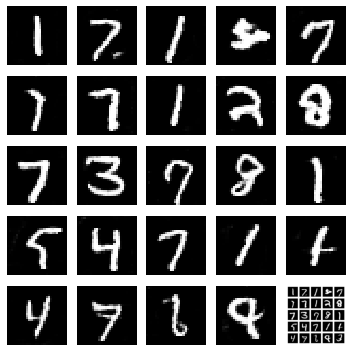

100%|██████████| 350/350 [00:18<00:00, 19.07it/s]


Epoch number: 178 discriminator_loss: 0.49362066652093617 generator_loss: 1.9456487948553902


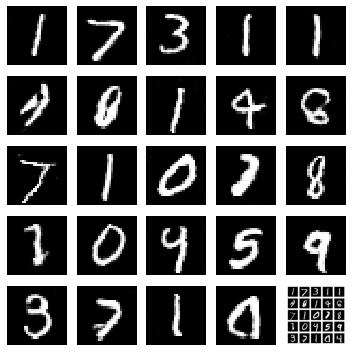

100%|██████████| 350/350 [00:18<00:00, 18.96it/s]


Epoch number: 179 discriminator_loss: 0.4924820667505264 generator_loss: 1.951932143824441


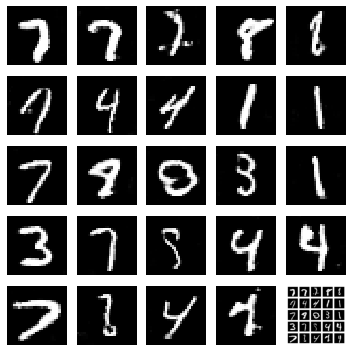

100%|██████████| 350/350 [00:18<00:00, 19.04it/s]


Epoch number: 180 discriminator_loss: 0.49568799802235197 generator_loss: 1.9498641627175468


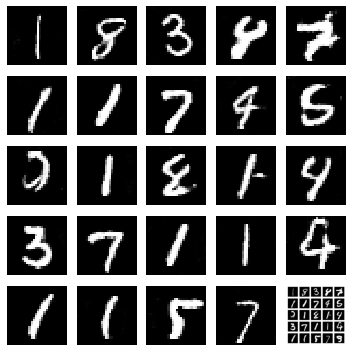

100%|██████████| 350/350 [00:18<00:00, 19.16it/s]


Epoch number: 181 discriminator_loss: 0.49281856426170895 generator_loss: 1.9554398781912667


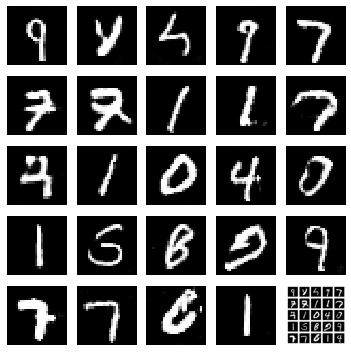

100%|██████████| 350/350 [00:18<00:00, 18.93it/s]


Epoch number: 182 discriminator_loss: 0.49157877096108027 generator_loss: 1.954423919064658


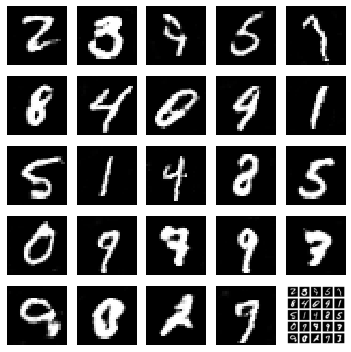

100%|██████████| 350/350 [00:18<00:00, 18.92it/s]


Epoch number: 183 discriminator_loss: 0.4952371426139559 generator_loss: 1.9496871396473476


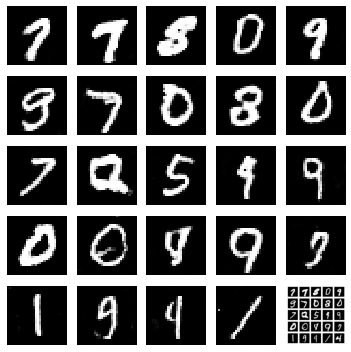

100%|██████████| 350/350 [00:18<00:00, 19.06it/s]


Epoch number: 184 discriminator_loss: 0.49592701085976193 generator_loss: 1.9567285799980163


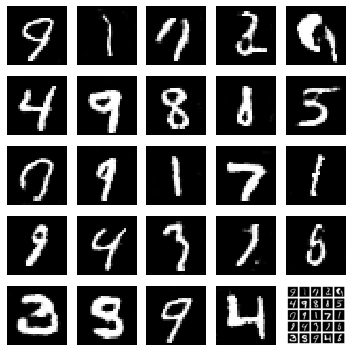

100%|██████████| 350/350 [00:18<00:00, 19.05it/s]


Epoch number: 185 discriminator_loss: 0.49234423492636 generator_loss: 1.9572901133128575


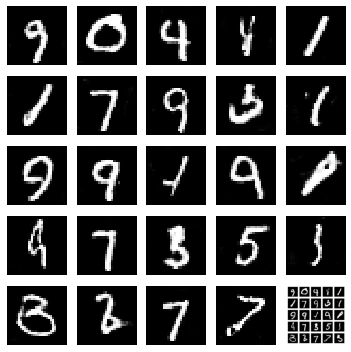

100%|██████████| 350/350 [00:18<00:00, 19.06it/s]


Epoch number: 186 discriminator_loss: 0.4915129240070071 generator_loss: 1.9631319958823068


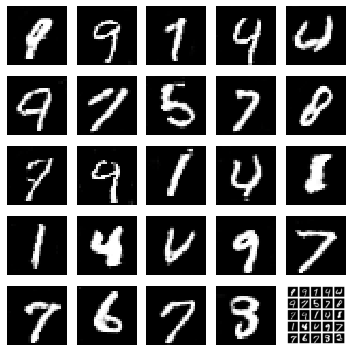

100%|██████████| 350/350 [00:18<00:00, 18.88it/s]


Epoch number: 187 discriminator_loss: 0.4936823373181479 generator_loss: 1.961486837523324


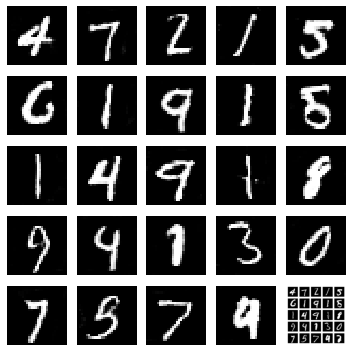

100%|██████████| 350/350 [00:18<00:00, 19.19it/s]


Epoch number: 188 discriminator_loss: 0.4921844684226172 generator_loss: 1.966669363294329


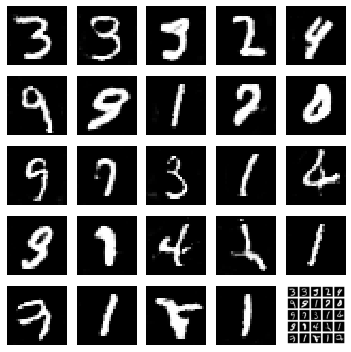

100%|██████████| 350/350 [00:18<00:00, 19.10it/s]


Epoch number: 189 discriminator_loss: 0.49140884595257894 generator_loss: 1.9777503490447998


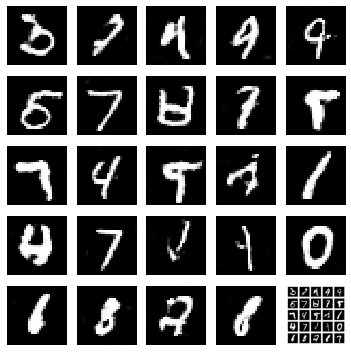

100%|██████████| 350/350 [00:18<00:00, 19.08it/s]


Epoch number: 190 discriminator_loss: 0.48906549990177156 generator_loss: 1.9767502978869846


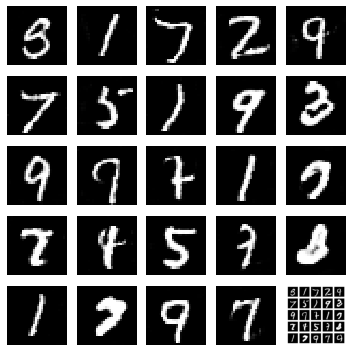

100%|██████████| 350/350 [00:18<00:00, 19.12it/s]


Epoch number: 191 discriminator_loss: 0.4939482511792864 generator_loss: 1.9741033363342284


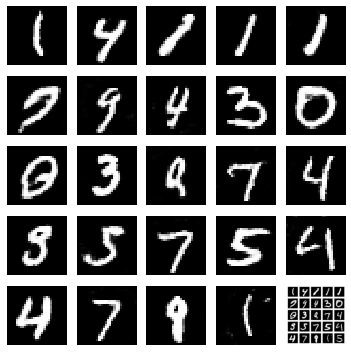

100%|██████████| 350/350 [00:18<00:00, 18.99it/s]


Epoch number: 192 discriminator_loss: 0.4889124365363802 generator_loss: 1.9818329736164637


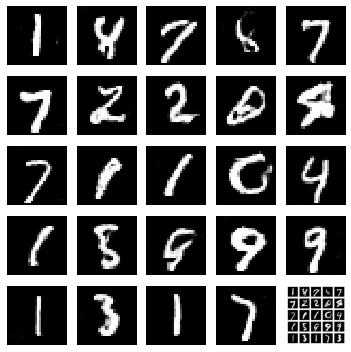

100%|██████████| 350/350 [00:18<00:00, 19.24it/s]


Epoch number: 193 discriminator_loss: 0.48989388814994267 generator_loss: 1.9788666197231837


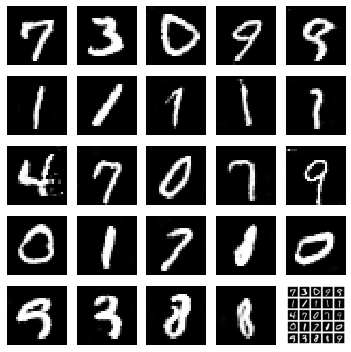

100%|██████████| 350/350 [00:18<00:00, 19.10it/s]


Epoch number: 194 discriminator_loss: 0.48910426199436186 generator_loss: 1.9904144763946534


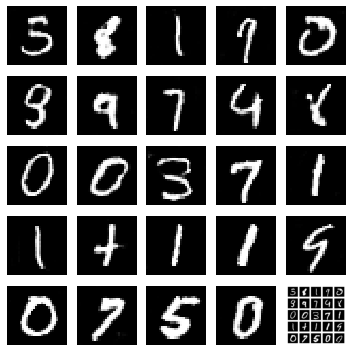

100%|██████████| 350/350 [00:18<00:00, 19.19it/s]


Epoch number: 195 discriminator_loss: 0.48986042874200003 generator_loss: 1.9987545268876212


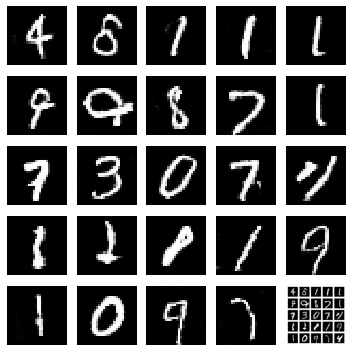

100%|██████████| 350/350 [00:18<00:00, 19.08it/s]


Epoch number: 196 discriminator_loss: 0.48887399205139703 generator_loss: 1.9871189996174403


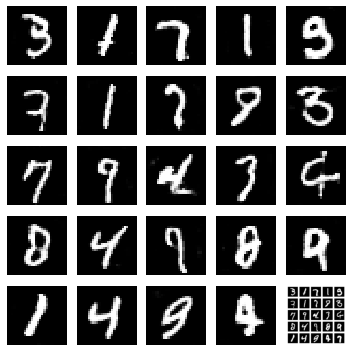

100%|██████████| 350/350 [00:18<00:00, 19.00it/s]


Epoch number: 197 discriminator_loss: 0.4886156060865947 generator_loss: 1.9931121826171876


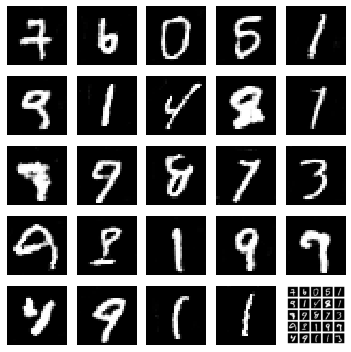

100%|██████████| 350/350 [00:18<00:00, 19.01it/s]


Epoch number: 198 discriminator_loss: 0.49088658681937625 generator_loss: 1.9881949472427367


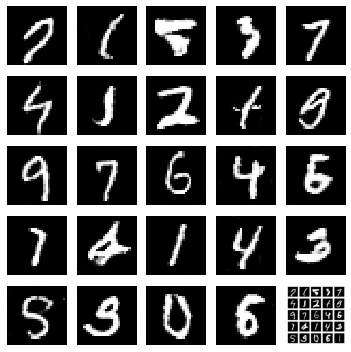

100%|██████████| 350/350 [00:18<00:00, 18.45it/s]


Epoch number: 199 discriminator_loss: 0.48923484674521855 generator_loss: 1.9811262576920645


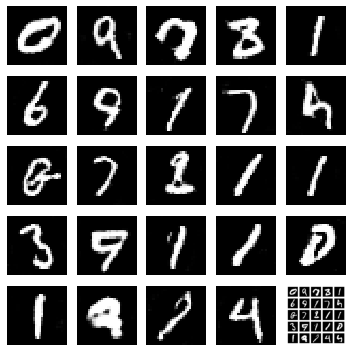

In [0]:
# To see some progress, we use tqdm as a progress bar
from tqdm import tqdm

history = {"discriminator":[],"generator":[]}

# Main training loop
for epoch_num in range(EPOCHS):
    epoch_discriminator_loss = 0
    epoch_generator_loss = 0
    
    for batch in tqdm(range(BATCH_NUM)):
        # We select randomly a half batch amount of real images from MNIST
        # Use Numpy to choose, no replacement!
        real_images = data[np.random.randint(low=0,
                                             high=data.shape[0],
                                             size=HALF_BATCH)]
        
        # We generate a half batch amount of fake images
        # By first generating a half batch worth of Gaussian noise with zero mean, unit variance
        # and appropriate noise dimensions
        input_noise = np.random.normal(0,1, size=(HALF_BATCH,Z_DIM))
        # And then using the fixed generator, to output some images from it
        # Using the predict method of the generator!
        generated_images = generator.predict(input_noise)
        
        # We generate our "labels"
        # Remember one sided label smoothing for the positive class!
        # Let's say with 0.9...
        # So please, generate a half batch sized, one dimensional matrix with ones, using numpy
        # and multiuply it by 0.9
        real_y = np.ones(HALF_BATCH)*0.9
        # And generate a half batch worth of zeroes, again one dimensional matrix
        generated_y = np.zeros(HALF_BATCH)

        
        ### We do the actual training!
        
        # First for the discriminator on the real data
        discriminator_loss_real = discriminator.train_on_batch(real_images, real_y)
        
        # Then on the fake data
        discriminator_loss_generated = discriminator.train_on_batch(generated_images, generated_y)
        
        # Then average the two losses
        discriminator_loss = (discriminator_loss_real + discriminator_loss_generated) / 2
        epoch_discriminator_loss += discriminator_loss
        
        ### We then update the generator
        # We use the discriminator that was trained a line above, and is frozen, as defined in the joint model
        
        # Please generate a new set of input noise, notice, it is a full batch!
        # Again, using numpy, normal distribution, zero mean, unit variance
        new_input_noise = np.random.normal(0,1, [BATCH_SIZE, Z_DIM])
        
        # We try to convince the discriminator, that this is real data - which is not
        # So please generate a batch worht of one dimensional matrix filled with ones 
        convincing_y = np.ones(BATCH_SIZE) 
        # Notice, no label smoothing!

        # Remember, the joint model takes in noise, does the generation, the discrimination, then computes loss
        # But the discriminator is frozen, so only the generator will get updated
        # It is "successful" if the discriminator predicts "real" - hence the convincing_y
        generator_loss = joint_model.train_on_batch(new_input_noise, convincing_y)
        epoch_generator_loss += generator_loss
        
    # Loss printout in every epoch, averaged over the batches
    print("Epoch number:",epoch_num,"discriminator_loss:",epoch_discriminator_loss / BATCH_NUM, "generator_loss:", epoch_generator_loss / BATCH_NUM)
    
    # Save it for the future
    history["discriminator"].append(epoch_discriminator_loss / BATCH_NUM)
    history["generator"].append(epoch_generator_loss / BATCH_NUM)
    
    #Save model - optional
    #generator.save("generator.h5")
    
    #Save images
    get_example_images(epoch_num)
    
    # Show epoch example
    show_image_for_epoch(epoch_num)

## Visualization of training progress

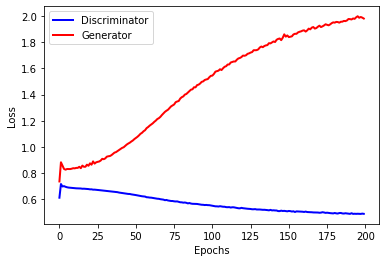

In [0]:
plt.plot(history["discriminator"], color='blue', linewidth=2, label="Discriminator")
plt.plot(history["generator"],  color='red', linewidth=2, label="Generator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
